In [1]:
# Set OpenMP environment variables early to avoid libiomp conflicts
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")

import numpy as np
import pandas as pd
import sympy as sy

# Try importing torch, but don't fail if it's not available
try:
    import torch
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} is available")
except ImportError:
    TORCH_AVAILABLE = False
    print("Warning: PyTorch is not installed. Using numpy/scipy for diagonalization.")
    torch = None

import ujson as uj

from copy import deepcopy
from functools import partial
from pathlib import Path

from sympy.physics.wigner import wigner_3j, wigner_6j
from numpy import linalg as LA
from IPython.display import Latex, display
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import norm

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels
from Energy_Levels_old import (
    branching_ratios,
    Calculate_TDMs,
    Calculate_TDM_evecs,
    Calculate_forbidden_TDM_evecs,
    Calculate_forbidden_TDMs,
)

print("All imports successful!")

# sns.set()
# sns.set_palette('bright')
# np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate

PyTorch 2.5.1+cu121 is available
All imports successful!


In [2]:
# Torch device configuration and GPU-ready diagonalization hooks
# Only configure torch if it's available. Probe CUDA in a short subprocess
# and default to CPU if the probe fails to avoid kernel/driver crashes.
import subprocess, sys, time

if TORCH_AVAILABLE:
    try:
        # Default to CPU; enable CUDA only if a quick safe probe succeeds.
        TORCH_DEVICE = torch.device("cpu")
        cuda_ok = False
        if torch.cuda.is_available():
            probe_code = (
                "import torch, sys\n"
                "try:\n"
                "    x = torch.tensor([1.0], dtype=torch.float32).to('cuda')\n"
                "    torch.cuda.synchronize()\n"
                "    print('cuda_ok')\n"
                "except Exception as e:\n"
                "    print('cuda_fail', e)\n"
                "    sys.exit(1)\n"
            )
            try:
                res = subprocess.run([sys.executable, "-c", probe_code], capture_output=True, text=True, timeout=10)
                if res.returncode == 0 and "cuda_ok" in res.stdout:
                    TORCH_DEVICE = torch.device("cuda")
                    cuda_ok = True
                else:
                    print("CUDA probe failed; output:", res.stdout, res.stderr)
            except Exception as e:
                print("CUDA probe subprocess error:", e)

        print(f"Using torch device: {TORCH_DEVICE} (cuda_ok={cuda_ok})")
    except Exception as e:
        print(f"Warning: Could not configure torch device: {e}")
        TORCH_AVAILABLE = False
        TORCH_DEVICE = torch.device("cpu")
else:
    TORCH_DEVICE = None
    print("Torch not available, using numpy/scipy for diagonalization")

# Store original functions
if not hasattr(EL, "diagonalize_cpu"):
    EL.diagonalize_cpu = EL.diagonalize
    EL.diagonalize_batch_cpu = EL.diagonalize_batch

# ---- GPU profiling statistics ----
GPU_PROFILING = {
    "diagonalize_calls": 0,
    "diagonalize_cuda_calls": 0,
    "diagonalize_cpu_calls": 0,
    "diagonalize_batch_calls": 0,
    "diagonalize_batch_cuda_calls": 0,
    "diagonalize_batch_cpu_calls": 0,
    "total_time_cuda": 0.0,
    "total_time_cpu": 0.0,
    "total_time_batch_cuda": 0.0,
    "total_time_batch_cpu": 0.0,
}

def print_gpu_profile():
    """Print GPU profiling summary."""
    print("\n" + "="*70)
    print("GPU PROFILING SUMMARY")
    print("="*70)
    print(f"Single diagonalize() calls: {GPU_PROFILING['diagonalize_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_cuda_calls']} (total time: {GPU_PROFILING['total_time_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_cpu_calls']} (total time: {GPU_PROFILING['total_time_cpu']:.4f}s)")
    print(f"\nBatch diagonalize_batch() calls: {GPU_PROFILING['diagonalize_batch_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_batch_cuda_calls']} (total time: {GPU_PROFILING['total_time_batch_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_batch_cpu_calls']} (total time: {GPU_PROFILING['total_time_batch_cpu']:.4f}s)")
    if GPU_PROFILING['diagonalize_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_cpu_calls'] > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / GPU_PROFILING['diagonalize_cuda_calls']
        avg_cpu = GPU_PROFILING['total_time_cpu'] / GPU_PROFILING['diagonalize_cpu_calls']
        speedup = avg_cpu / avg_cuda if avg_cuda > 0 else 1.0
        print(f"\nSpeedup (single): {speedup:.2f}x (CUDA avg: {avg_cuda:.6f}s, CPU avg: {avg_cpu:.6f}s)")
    if GPU_PROFILING['diagonalize_batch_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_batch_cpu_calls'] > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / GPU_PROFILING['diagonalize_batch_cuda_calls']
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / GPU_PROFILING['diagonalize_batch_cpu_calls']
        speedup_b = avg_cpu_b / avg_cuda_b if avg_cuda_b > 0 else 1.0
        print(f"Speedup (batch): {speedup_b:.2f}x (CUDA avg: {avg_cuda_b:.6f}s, CPU avg: {avg_cpu_b:.6f}s)")
    print("="*70 + "\n")

# Patch the diagonalize function in the Energy_Levels module
# This ensures internal calls to diagonalize() use our patched version
def diagonalize_with_device(matrix, method="torch", order=False, Normalize=False, round=10):
    """GPU/CPU-aware diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_cuda_calls"] += 1
                # Some CUDA builds/drivers crash on float64 eigh; use float32 on device for stability
                tensor = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensor)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().astype(np.float64).T, round)
            else:
                GPU_PROFILING["diagonalize_cpu_calls"] += 1
                tensor = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensor)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().T, round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_cpu"] += elapsed
                
            if order:
                idx_order = np.argsort(evals)
                evecs = evecs[idx_order, :]
                evals = evals[idx_order]
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_cpu(matrix, method=method, order=order, Normalize=Normalize, round=round)


def diagonalize_batch_with_device(matrix_array, method="torch", round=10):
    """GPU/CPU-aware batch diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_batch_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix_array)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_batch_cuda_calls"] += 1
                tensors = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensors)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1).astype(np.float64), round)
            else:
                GPU_PROFILING["diagonalize_batch_cpu_calls"] += 1
                tensors = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensors)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1), round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_batch_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_batch_cpu"] += elapsed
                
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch batch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_batch_cpu(matrix_array, method=method, round=round)


# Patch the functions in the module namespace
# This replaces the function references so internal calls use the patched version
EL.diagonalize = diagonalize_with_device
EL.diagonalize_batch = diagonalize_batch_with_device
if TORCH_AVAILABLE:
    EL.TORCH_DEVICE = TORCH_DEVICE

print("Diagonalization functions configured successfully.")
print(f"Default method: {'torch (GPU-accelerated)' if (TORCH_AVAILABLE and TORCH_DEVICE.type == 'cuda') else 'torch (CPU)' if TORCH_AVAILABLE else 'numpy'}")

Using torch device: cuda (cuda_ok=True)
Diagonalization functions configured successfully.
Default method: torch (GPU-accelerated)


In [3]:
import Energy_Levels_old as EL, torch
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))
print("EL.diagonalize:", EL.diagonalize.__name__)

EL.TORCH_DEVICE: cuda
EL.diagonalize: diagonalize_with_device


In [4]:
# Python
import torch, Energy_Levels_old as EL, time
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda runtime version:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))

torch: 2.5.1+cu121
cuda available: True
cuda runtime version: 12.1
device count: 1
device name: NVIDIA RTX A2000
EL.TORCH_DEVICE: cuda


In [5]:
X010_173 = MoleculeLevels.initialize_state(
    "YbOH",
    "173",
    "X010",
    [1, 2],
    M_values="all",
    I=[5 / 2, 1 / 2],
    S=1 / 2,
    round=8,
    P_values=[1 / 2, 3 / 2],
)

BASE_PARAMETERS = deepcopy(X010_173.parameters)
FIT_PARAMETER_NAMES = [
    "Be",
    "Gamma_SR",
    "Gamma_Prime",
    "bFYb",
    "cYb",
    "bFH",
    "cH",
    "e2Qq0",
    "q_lD",
    "p_lD",
    "muE",
    "g_S_eff",
]
PARAM_PRIORS = {key: BASE_PARAMETERS[key] for key in FIT_PARAMETER_NAMES}


def _default_bound(value, frac=0.2, floor=1e-6):
    span = max(abs(value) * frac, floor)
    return value - span, value + span


FIT_PARAMETER_BOUNDS = {key: _default_bound(PARAM_PRIORS[key]) for key in FIT_PARAMETER_NAMES}

print(f"Loaded {X010_173.iso_state} with {len(FIT_PARAMETER_NAMES)} fit parameters tracked.")

Loaded 173X010 with 12 fit parameters tracked.


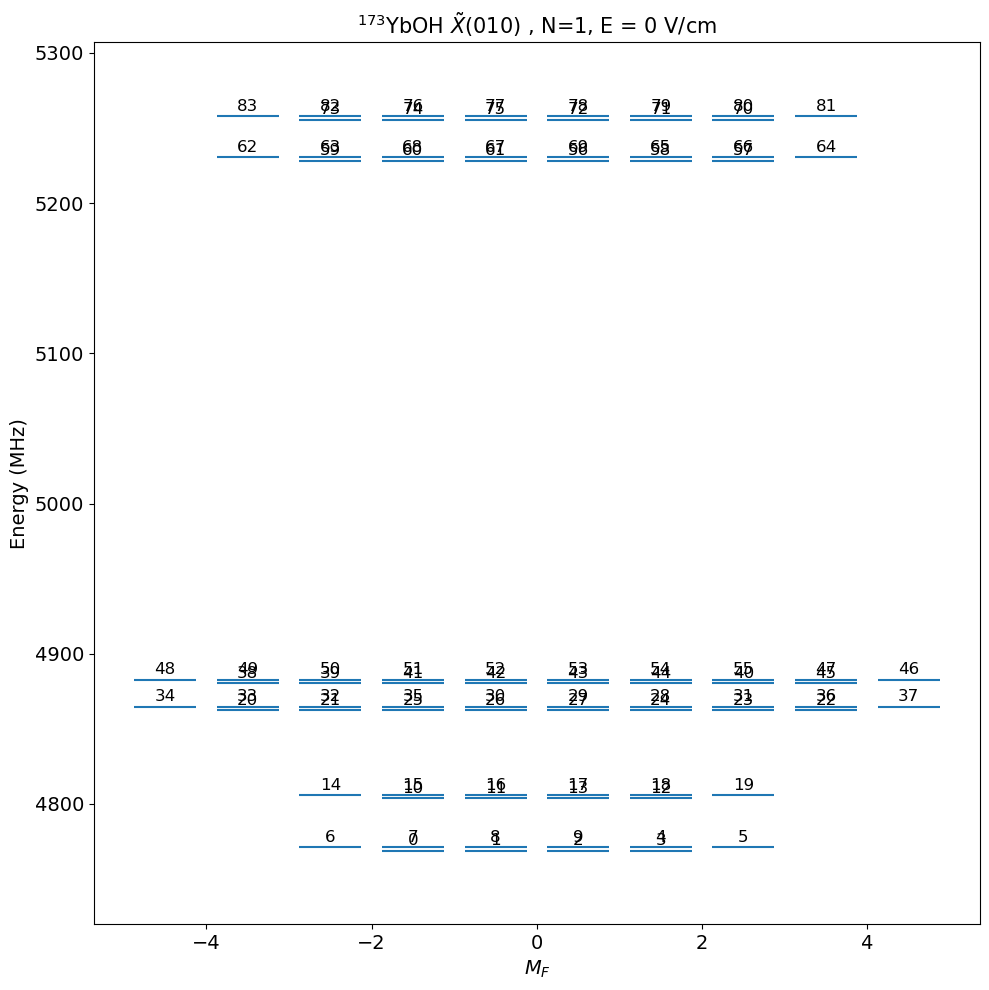

In [26]:
Efield = 0
X010_173.display_PTV(Efield,1e-8,'all',step_B = 1e-4, step_E = 1e-2, idx = X010_173.select_q({'N':1, 'G':3}),round=4,figsize=(10,10),off = 0, scale2 = 1.2, plot_state_index = True, plot_CPV = False, plot_only_one_CPV = None, fontsize_for_values = 12)
plt.title(X010_173.state_str + ' , N=1, E = {} V/cm'.format(X010_173.E0),fontsize=15)
#plt.yticks(np.linspace(4700,5300,301))
#plt.ylim(5250,5300)
plt.tight_layout()
plt.show()
#plt.savefig('MQM_science_state_level_diagram_20230313_173_all_shifts_' + str(Efield) + 'Vcm.pdf')

In [7]:
def set_state_parameters(state, updates=None):
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)

    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params

    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers,
        params=new_params,
        M_values=state.M_values,
        precision=state.round,
    )

    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)



def parameter_vector_to_dict(vector):
    return {name: value for name, value in zip(FIT_PARAMETER_NAMES, vector)}


def current_parameter_dict(state=None):
    source = state.parameters if state is not None else BASE_PARAMETERS
    return {name: source[name] for name in FIT_PARAMETER_NAMES}


def parameters_to_vector(params):
    return np.array([params[name] for name in FIT_PARAMETER_NAMES], dtype=float)

set_state_parameters(X010_173)
baseline_parameter_vector = parameters_to_vector(current_parameter_dict(X010_173))

In [8]:

# Frequency transform controls (matching the previous plotting convention)
FREQ_OFFSET = 0  # MHz
FREQ_SCALE = 1  # Divide by two for two-photon frequency conversion
FREQ_SHIFT = 0  # Additional shift applied after scaling


def model_frequency_transform(raw_freq):
    """Map raw transition frequency from the model to the experimental frequency axis."""
    return (raw_freq - FREQ_OFFSET) * FREQ_SCALE + FREQ_SHIFT


# indices 38–55 and 70–83 (inclusive)
TRANSITION_INDEX_SET = list(range(38, 56)) + list(range(70, 84))
print(TRANSITION_INDEX_SET)
LASER_POLARIZATION = "both"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 0  # Update if the experimental conditions change
B_FIELD = 1e-8

[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


In [9]:
def compute_model_transitions(
    state,
    Ez=EZ_FIELD,
    B=B_FIELD,
    indices=None,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=None,
):
    """
    Compute model transitions with optional state index filtering.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None, optional
        Filter transitions to specific state index pairs.
        Format: [((lower_min, lower_max), (upper_min, upper_max)), ...]
        Example: [((46, 55), (76, 83)), ((38, 45), (70, 75))]
    """
    index_list = indices if indices is not None else TRANSITION_INDEX_SET
    if index_list is None:
        index_list = list(range(84))

    result = state.calculate_two_photon_spectrum(
        Ez,
        B,
        index_list,
        parity_sign=parity_sign,
        laser_polarization=polarization,
        allowed_transitions=allowed_transitions,
    )
    transitions = pd.DataFrame(result[1])

    if not transitions.empty:
        transitions["freq_model"] = transitions["freq"].apply(model_frequency_transform)
        if INTENSITY_THRESHOLD is not None:
            intensity_key = next(
                (key for key in ["intensity", "Intensity", "strength"] if key in transitions.columns),
                None,
            )
            if intensity_key is not None:
                transitions = transitions[transitions[intensity_key] >= INTENSITY_THRESHOLD].reset_index(drop=True)

    return transitions, result


def merge_predictions_with_experiment(predicted_df, experimental_df):
    if experimental_df.empty:
        predicted_df = predicted_df.copy()
        predicted_df["freq_obs"] = np.nan
        predicted_df["residual"] = np.nan
        predicted_df["weight"] = 1.0
        return predicted_df, pd.DataFrame(), predicted_df

    merge_cols = ["state index 0", "state index 1"]
    for col in ["M0", "M1"]:
        if col in experimental_df.columns and col in predicted_df.columns:
            merge_cols.append(col)

    merged = experimental_df.merge(predicted_df, how="left", on=merge_cols, suffixes=("_obs", "_model"))
    missing = merged[merged["freq_model"].isna()].copy()

    merged["freq_model"] = merged["freq_model"].astype(float)
    merged["residual"] = merged["freq_model"] - merged["freq_obs"]
    if "uncertainty" in merged.columns:
        weights = merged["uncertainty"].replace(0, np.nan).fillna(1.0)
    else:
        weights = pd.Series(1.0, index=merged.index)
    merged["weight"] = weights
    merged["weighted_residual"] = merged["residual"] / merged["weight"]

    matched = merged[merged["freq_model"].notna()].copy()
    return matched, missing, predicted_df


def summarize_fit(matched_df):
    if matched_df.empty:
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    valid = np.isfinite(matched_df["residual"]) & np.isfinite(matched_df["weight"])
    if not valid.any():
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    residuals = matched_df.loc[valid, "residual"].to_numpy()
    weights = matched_df.loc[valid, "weight"].to_numpy()
    rms = np.sqrt(np.mean(residuals**2))
    weighted_rms = np.sqrt(np.mean((residuals / weights) ** 2))
    return {"rms": rms, "weighted_rms": weighted_rms, "n_points": int(valid.sum())}

In [111]:
uncertainty_factor = 1


import importlib.util
from pathlib import Path

# ---------------------------
# Load molecule_parameters.py
# ---------------------------
MP_PATH = Path("molecule_parameters.py")  # if it's in the notebook folder
if not MP_PATH.exists():
    # if needed, point to your uploaded path or repo path:
    MP_PATH = Path("/mnt/data/molecule_parameters.py")

spec = importlib.util.spec_from_file_location("molecule_parameters", str(MP_PATH))
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

# ---------------------------------------------------------
# Read the parameter MEANS for YbOH 173X010 (includes general)
# ---------------------------------------------------------
# This is the clean merged dict that your library likely expects:
params_173X010_mean = dict(mp.all_params["YbOH"]["173X010"])  # includes params_general
# alternatively: params_173X010_mean = {**mp.params_173X010, **mp.params_general}

# (Optional) apply these as the baseline parameters to your state
# Use only keys your state actually supports, to avoid KeyError downstream.
state_supported = set(current_parameter_dict(X010_173).keys())
params_173X010_mean_filtered = {k: v for k, v in params_173X010_mean.items() if k in state_supported}

set_state_parameters(X010_173, params_173X010_mean_filtered)

print("Loaded params for 173X010 (filtered to state):")
for k in sorted(params_173X010_mean_filtered.keys()):
    print(f"  {k:12s} = {params_173X010_mean_filtered[k]}")

# ---------------------------------------------------------
# Define / build UNCERTAINTIES (sigmas) -> you must supply these
# ---------------------------------------------------------
# Recommended: make a dict with 1-sigma uncertainties in the SAME UNITS as params.
# If you don't have them yet, start with fractional placeholders.
PARAM_SIGMA_173X010 = {
    # Fill these with your measured 1-sigma uncertainties (MHz etc.)
    # Examples (PLACEHOLDERS — replace with real numbers):
    "Be": 0.4*uncertainty_factor,
    "Gamma_SR": 3*uncertainty_factor,
    "Gamma_Prime": 4*uncertainty_factor,
    "bFYb": 0.8*uncertainty_factor,
    "cYb": 10*uncertainty_factor,
    "e2Qq0": 27*uncertainty_factor,
    "q_lD": 0.5*uncertainty_factor,
    "p_lD": 5*uncertainty_factor,
    "muE": 0.01 * 0.503412 *uncertainty_factor, 
    "g_S_eff": 0.02*uncertainty_factor,
}

# Fractional fallback if sigma not provided:
FRACTIONAL_SIGMA_FALLBACK = {
    "Be": 1e-4,
    "Gamma_SR": 2e-2,
    "Gamma_Prime": 2e-2,
    "bFYb": 5e-3,
    "cYb": 5e-2,
    "e2Qq0": 1e-2,
    "q_lD": 5e-2,
    "p_lD": 5e-2,
    "muE": 5e-3,
    "g_S_eff": 5e-3,
}

# Build priors: PARAM_PRIORS[name] = (mean, sigma)
PARAM_PRIORS = {}
for k, mu in params_173X010_mean_filtered.items():
    if k in PARAM_SIGMA_173X010:
        sig = float(PARAM_SIGMA_173X010[k])
    else:
        frac = float(FRACTIONAL_SIGMA_FALLBACK.get(k, 0.05))  # default 5% if unknown
        sig = abs(float(mu)) * frac if float(mu) != 0 else frac
    if sig <= 0:
        continue
    PARAM_PRIORS[k] = (float(mu), float(sig))

print("\nBuilt PARAM_PRIORS (mean, sigma):")
for k in sorted(PARAM_PRIORS.keys()):
    mu, sig = PARAM_PRIORS[k]
    print(f"  {k:12s} : mu={mu:.6g}, sigma={sig:.6g}")


Loaded params for 173X010 (filtered to state):
  Be           = 7334.130786908366
  Gamma_Prime  = 14.233846113382
  Gamma_SR     = -87.18714159785
  bFH          = 4.07
  bFYb         = -1880.9665339648823
  cH           = 3.49
  cYb          = -92.159499306238
  e2Qq0        = -3149
  g_S_eff      = 2.07
  muE          = 1.08736992
  p_lD         = 12.766362031472
  q_lD         = 12.494150479608

Built PARAM_PRIORS (mean, sigma):
  Be           : mu=7334.13, sigma=0.4
  Gamma_Prime  : mu=14.2338, sigma=4
  Gamma_SR     : mu=-87.1871, sigma=3
  bFH          : mu=4.07, sigma=0.2035
  bFYb         : mu=-1880.97, sigma=0.8
  cH           : mu=3.49, sigma=0.1745
  cYb          : mu=-92.1595, sigma=10
  e2Qq0        : mu=-3149, sigma=27
  g_S_eff      : mu=2.07, sigma=0.02
  muE          : mu=1.08737, sigma=0.00503412
  p_lD         : mu=12.7664, sigma=5
  q_lD         : mu=12.4942, sigma=0.5


In [112]:
import numpy as np
import pandas as pd
from pathlib import Path


# -----------------------------
# Unassigned multi-spectrum data loading
# -----------------------------
UNASSIGNED_DATA_PATH = Path("synthetic_peaks.csv")  # or your real CSV
UNASSIGNED_SIGMA = 0.05  # MHz Gaussian broadening (100 kHz) used in loss and plotting

# Fallback defaults ONLY used if you call the model without Ez/B explicitly
DEFAULT_EZ_FIELD = 0.0
DEFAULT_B_FIELD = 1e-8

# Load peak-list data (must contain these columns)
dfu = pd.read_csv(UNASSIGNED_DATA_PATH)
required = ["spectrum_id", "Ez_V_per_cm", "Bz_G", "nu_obs_MHz"]
missing = [c for c in required if c not in dfu.columns]
if missing:
    raise ValueError(f"Unassigned spectrum CSV missing columns: {missing}")

dfu["nu_obs_MHz"] = pd.to_numeric(dfu["nu_obs_MHz"], errors="coerce")
dfu = dfu.dropna(subset=["nu_obs_MHz"]).reset_index(drop=True)

OBS_SPECTRA = []
for sid, g in dfu.groupby("spectrum_id", sort=False):
    Ez = float(g["Ez_V_per_cm"].iloc[0])
    Bz = float(g["Bz_G"].iloc[0])
    freqs = np.sort(g["nu_obs_MHz"].to_numpy(dtype=float))
    OBS_SPECTRA.append({"id": sid, "Ez": Ez, "B": Bz, "freqs": freqs})

print("Loaded spectra:", [(s["id"], len(s["freqs"]), s["Ez"], s["B"]) for s in OBS_SPECTRA])


# -----------------------------
# Unassigned spectrum comparison machinery
# -----------------------------
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, axis=None, **kwargs):
    """Gaussian broadening that accepts either freq_axis= or axis= (or positional axis).

    This is defensive so later callers passing freq_axis won't break if an older
    signature (freqs, weights, axis, sigma) was in scope.
    """
    frequencies = np.asarray(frequencies, float)
    if weights is None:
        weights = np.ones_like(frequencies)
    else:
        weights = np.asarray(weights, float)

    # Accept either freq_axis or axis (keyword or positional via kwargs.get)
    if freq_axis is None:
        freq_axis = axis if axis is not None else kwargs.pop("axis", None)

    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min = frequencies.min() - 3 * sigma
        f_max = frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)

    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)

    diff = freq_axis[:, None] - frequencies[None, :]
    spec = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spec


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    """
    Compare two unassigned peak lists by converting each into a Gaussian-broadened "spectrum"
    on a shared frequency axis and computing RMS difference.
    
    MODIFIED: Now computes UNNORMALIZED RMS to preserve absolute spectral position information.
    This means the loss function will penalize frequency shifts, not just shape mismatches.
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)

    # Choose a shared axis covering both
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    if predicted_freqs.size == 0:
        fmin, fmax = observed_freqs.min(), observed_freqs.max()
    elif observed_freqs.size == 0:
        fmin, fmax = predicted_freqs.min(), predicted_freqs.max()
    else:
        fmin = min(predicted_freqs.min(), observed_freqs.min())
        fmax = max(predicted_freqs.max(), observed_freqs.max())

    axis = np.linspace(fmin - 3*sigma, fmax + 3*sigma, 2000)

    _, pred_spec = gaussian_broadened_spectrum(predicted_freqs, weights=predicted_weights, freq_axis=axis, sigma=sigma)
    _, obs_spec  = gaussian_broadened_spectrum(observed_freqs,  weights=observed_weights,  freq_axis=axis, sigma=sigma)

    # MODIFIED: Keep spectra UNNORMALIZED to preserve absolute position information
    # This way, if peaks are shifted in frequency, the loss will be higher
    # We still normalize by the max of observed spectrum to keep loss scale reasonable
    norm_factor = obs_spec.max() if obs_spec.max() > 0 else 1.0
    pred_spec = pred_spec / norm_factor
    obs_spec  = obs_spec  / norm_factor

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))


def spectral_residual_absolute_position(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA, enforce_observed_coverage=True, match_tolerance=0.5):
    """
    Loss function that optimizes for absolute spectral position overlap.
    
    CONSTRAINT: All observed peaks MUST have a corresponding predicted peak nearby.
    
    Parameters:
    -----------
    predicted_freqs : array
        Predicted transition frequencies
    observed_freqs : array
        Observed peak frequencies
    enforce_observed_coverage : bool (default=True)
        If True: HEAVILY penalizes any observed peak without a nearby predicted peak
        If False: Uses bidirectional distance (old behavior)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched"
        
    Loss components:
    1. PRIMARY (if enforce_observed_coverage=True): 
       - For each observed peak, find nearest predicted peak
       - Penalize: distance to match + penalty if no match within tolerance
    2. SECONDARY:
       - Penalty for each unmatched predicted peak (but allows extra predictions)
    3. OVERALL:
       - Encourages all observed peaks to be covered by predictions
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)
    
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    
    # HARD CONSTRAINT: If no predicted peaks, heavy penalty
    if predicted_freqs.size == 0:
        return 100.0 + len(observed_freqs) * 10.0
    
    # If no observed peaks, no loss (but penalize extra predictions)
    if observed_freqs.size == 0:
        return len(predicted_freqs) * 0.5
    
    # ====== PRIMARY LOSS: Enforce that ALL observed peaks have predicted matches ======
    obs_to_pred_dist = []
    unmatched_count = 0
    
    for obs_freq in observed_freqs:
        min_dist = np.min(np.abs(predicted_freqs - obs_freq))
        obs_to_pred_dist.append(min_dist)
        
        # If this observed peak has no nearby predicted peak, it's unmatched
        if min_dist > match_tolerance:
            unmatched_count += 1
    
    avg_obs_to_pred = np.mean(obs_to_pred_dist)
    
    # HEAVY penalty for unmatched observed peaks (this is the key constraint!)
    unmatched_penalty = unmatched_count * 5.0
    
    # ====== SECONDARY LOSS: Penalize extra predicted peaks (less strongly) ======
    pred_to_obs_dist = []
    unmatched_pred_count = 0
    
    for pred_freq in predicted_freqs:
        min_dist = np.min(np.abs(observed_freqs - pred_freq))
        pred_to_obs_dist.append(min_dist)
        
        # If this predicted peak is far from any observed peak, it's extra
        if min_dist > match_tolerance:
            unmatched_pred_count += 1
    
    avg_pred_to_obs = np.mean(pred_to_obs_dist)
    
    # Lighter penalty for extra predicted peaks (we allow extra predictions)
    extra_pred_penalty = unmatched_pred_count * 0.5
    
    if enforce_observed_coverage:
        # PRIMARY: Force all observed peaks to be matched
        # SECONDARY: Lightly penalize extra predictions
        total_loss = avg_obs_to_pred + unmatched_penalty + extra_pred_penalty
    else:
        # Old behavior: bidirectional matching
        total_loss = avg_obs_to_pred + avg_pred_to_obs
    
    return float(total_loss)


def extract_transition_freqs(state, state_pairs, Ez=None, B=None, indices=None, **kwargs):
    """
    Extract predicted frequencies for transitions between specific state pairs.
    
    Parameters:
    -----------
    state_pairs : list of tuples or tuple
        List of (lower_range, upper_range) tuples specifying allowed transitions
        Each range is (min, max) inclusive.
        Example: [((38, 45), (70, 75))] extracts transitions between states 38-45 and 70-75
    Ez : float
        Electric field (V/cm)
    B : float
        Magnetic field (Gauss)
    
    Returns:
    --------
    freqs : array
        Frequencies of transitions matching the specified state pairs
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD
    
    # Convert single tuple to list
    if isinstance(state_pairs, tuple):
        state_pairs = [state_pairs]
    
    # Remove allowed_transitions from kwargs if present (we're providing our own)
    kwargs.pop('allowed_transitions', None)
    
    # Get transitions with the state pair constraint
    transitions, _ = compute_model_transitions(
        state, Ez=Ez, B=B, indices=indices, 
        allowed_transitions=state_pairs,
        **kwargs
    )
    
    if transitions is None or transitions.empty:
        return np.array([])
    
    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    return freqs


def check_peak_assignment_0V(state, observed_freqs_0V, indices=None, **kwargs):
    """
    Check how well the predicted spectrum at 0 V/cm matches the known peak assignments.
    
    Known assignment at 0 V/cm:
    - Lower frequency peak (left) → states 38-45 ↔ 70-75
    - Higher frequency peak (right) → states 46-55 ↔ 76-83
    
    Parameters:
    -----------
    observed_freqs_0V : array
        Observed peak frequencies at 0 V/cm (should have 2 elements: [lower, higher])
    
    Returns:
    --------
    assignment_loss : float
        Penalty for incorrect assignment (0 = perfect, higher = worse)
    """
    if len(observed_freqs_0V) < 2:
        return 0.0  # Can't check if we don't have 2 peaks
    
    # Sort observed peaks
    obs_lower = min(observed_freqs_0V)
    obs_higher = max(observed_freqs_0V)
    
    # Get predicted freqs for each assignment
    freqs_lower_pair = extract_transition_freqs(
        state, ((38, 45), (70, 75)), Ez=0, B=1e-8, indices=indices, **kwargs
    )
    freqs_higher_pair = extract_transition_freqs(
        state, ((46, 55), (76, 83)), Ez=0, B=1e-8, indices=indices, **kwargs
    )
    
    # Find best match for each observed peak to its expected transition set
    loss = 0.0
    
    # Penalty for lower peak not matching the lower pair
    if len(freqs_lower_pair) > 0:
        min_dist_lower = np.min(np.abs(freqs_lower_pair - obs_lower))
    else:
        min_dist_lower = 5.0  # Heavy penalty if no predictions for this pair
        loss += 10.0
    
    # Penalty for higher peak not matching the higher pair
    if len(freqs_higher_pair) > 0:
        min_dist_higher = np.min(np.abs(freqs_higher_pair - obs_higher))
    else:
        min_dist_higher = 5.0  # Heavy penalty if no predictions for this pair
        loss += 10.0
    
    # Add distance penalties
    loss += min_dist_lower + min_dist_higher
    
    return float(loss)


def transition_frequency_set(state, Ez=None, B=None, indices=None, **kwargs):
    """
    Returns predicted transition frequencies and weights for a given (Ez,B).
    FIX: no default args referencing EZ_FIELD/B_FIELD -> avoids NameError.
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD

    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions is None or transitions.empty:
        return np.array([]), np.array([]), raw

    # Try to pull an intensity/strength column if present
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy(dtype=float)
            break

    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    if weights is None:
        weights = np.ones_like(freqs)

    return freqs, weights, raw


def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA, use_absolute_position=True, enforce_observed_coverage=True, match_tolerance=1.0, enforce_0V_assignment=True, assignment_penalty_weight=10.0, **kwargs):
    """
    Average loss over many spectra, each with its own Ez/B.
    
    Parameters:
    -----------
    use_absolute_position : bool (default=True)
        If True, uses spectral_residual_absolute_position which directly optimizes peak positions.
        If False, uses the original spectral_residual with spectral shape comparison.
    enforce_observed_coverage : bool (default=True)
        If True: ALL observed peaks MUST have a nearby predicted peak (this is the constraint!)
        If False: Uses bidirectional matching (predicted peaks must also have observed counterparts)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched" (e.g., 1.0 MHz)
    enforce_0V_assignment : bool (default=True)
        If True: Enforce known peak assignments at 0 V/cm:
            - Lower freq peak ↔ states 38-45 to 70-75
            - Higher freq peak ↔ states 46-55 to 76-83
    assignment_penalty_weight : float (default=2.0)
        Weight factor for assignment penalty relative to main loss
    """
    losses = []
    assignment_losses = []
    
    for s in spectra:
        # Pass only the kwargs that transition_frequency_set needs
        pred_f, pred_w, _ = transition_frequency_set(state, Ez=s["Ez"], B=s["B"], indices=indices, **kwargs)
        
        if use_absolute_position:
            # Use absolute position loss with observed peak coverage constraint
            loss = spectral_residual_absolute_position(
                pred_f, s["freqs"], 
                predicted_weights=pred_w, 
                observed_weights=None, 
                sigma=sigma,
                enforce_observed_coverage=enforce_observed_coverage,
                match_tolerance=match_tolerance
            )
        else:
            # Use original spectral comparison (now with unnormalized spectra)
            loss = spectral_residual(pred_f, s["freqs"], 
                                    predicted_weights=pred_w, 
                                    observed_weights=None, 
                                    sigma=sigma)
        losses.append(loss)
        
        # ====== ADDITIONAL CONSTRAINT: Check 0 V/cm peak assignments ======
        if enforce_0V_assignment and s["Ez"] == 0.0:
            # At 0 V/cm, we know the peak assignments
            assignment_loss = check_peak_assignment_0V(
                state, s["freqs"], indices=indices,
                parity_sign=kwargs.get("parity_sign", PARITY_SIGN),
                polarization=kwargs.get("polarization", LASER_POLARIZATION),
                allowed_transitions=kwargs.get("allowed_transitions", None)
            )
            assignment_losses.append(assignment_loss)

    avg_loss = float(np.mean(losses)) if losses else np.inf
    
    # Add weighted assignment constraint
    if enforce_0V_assignment and assignment_losses:
        avg_assignment_loss = float(np.mean(assignment_losses))
        total_loss = avg_loss + assignment_penalty_weight * avg_assignment_loss
    else:
        total_loss = avg_loss
    
    return total_loss


Loaded spectra: [('spec0', 2, 0.0, 0.0), ('spec10', 4, 10.0, 0.0), ('spec20', 5, 20.0, 0.0), ('spec40', 7, 40.0, 0.0)]


In [47]:
# ============================================================================
# EXPERIMENTAL CONSTRAINTS: Allowed State Index Pairs
# ============================================================================
# Define experimentally-constrained transitions:
# - Transitions between states 46-55 and states 76-83
# - Transitions between states 38-45 and states 70-75

ALLOWED_TRANSITIONS = [
    ((46, 55), (76, 83)),  # First set of allowed transitions
    ((38, 45), (70, 75)),  # Second set of allowed transitions
]

print("Experimental constraints loaded:")
print(f"  - Transitions between states 46-55 ↔ 76-83")
print(f"  - Transitions between states 38-45 ↔ 70-75")
print(f"\nTo use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS")
print(f"to compute_model_transitions() or related functions.")
print(f"\nTo disable filtering (compute all transitions), use allowed_transitions=None")

Experimental constraints loaded:
  - Transitions between states 46-55 ↔ 76-83
  - Transitions between states 38-45 ↔ 70-75

To use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS
to compute_model_transitions() or related functions.

To disable filtering (compute all transitions), use allowed_transitions=None


Current molecular constants:
Be (rotational constant):           7334.100000 MHz
e2Qq0 (quadrupole coupling):        -3153.061000 MHz
Gamma_SR (hyperfine):               -87.187142 MHz
Gamma_Prime (hyperfine):            14.233846 MHz
bFYb (tensor interaction):          -1880.966534 MHz
cYb (tensor interaction):           -92.159499 MHz
q_lD (quad. field dependence):      12.494150 MHz/(V/cm)
p_lD (quad. field dependence):      12.766362 MHz/(V/cm)
muE (E-field sensitivity):          1.101295 MHz/(V/cm)

✓ Parameters applied to X010_173 state object
✓ Ready to run cell 13 to calculate spectrum


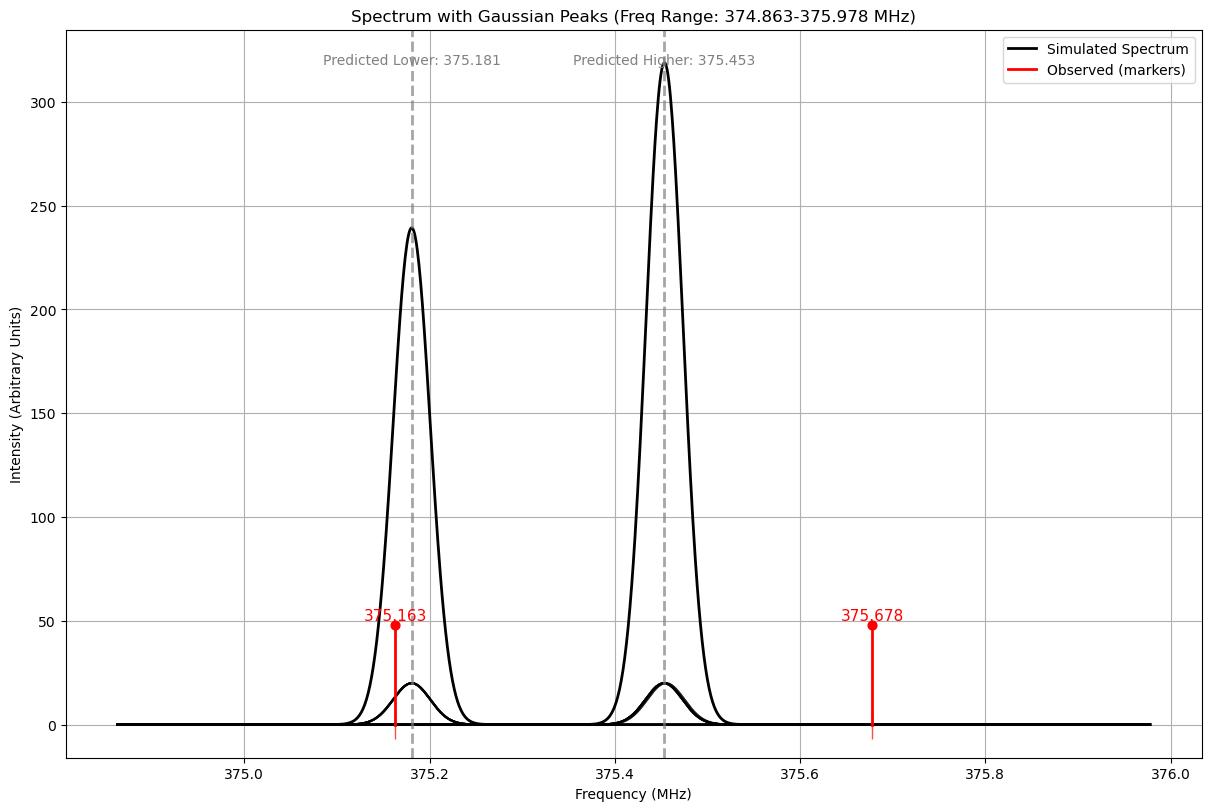

([375.18115235000005, 375.18115235000005, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.1806640699997, 375.453125, 375.453125, 375.453125, 375.453125, 375.453125, 375.453125, 375.453125, 375.453125, 375.453125, 375.4550781299995, 375.453125, 375.4550781299995, 375.4550781299995, 375.4550781299995, 375.453125, 375.453125], [{'freq': 375.18115235000005, 'state index 0': 38, 'energy 0': 4880.39550781, 'N0': 1, 'G0': 3, 'F10': 4, 'F0': 3, 'M0': -3, 'Parity0': 0.9999999910723506, 'state index 1': 70, 'energy 1': 5255.57666016, 'N1': 1, 'G1': 3, 'F11': 3, 'F1': 2, 'M1': -2, 'Parity1': 1.0000001576972974}, {'freq': 375.18115235000005, 'state index 0': 39, 'energy 0': 4880.39550781, 'N0': 1, 'G0': 3, 'F10': 4, 'F0': 3, 'M0': -2, 'Parity0': 0.9999999910723506, 'state index 1': 71, 'energy 1': 5255.57666016, 'N1': 1, 'G1': 3, 'F11': 3, 'F1': 2, 'M1': -1, 'Parity1': 1.0

In [78]:
# ============================================================
# MANUAL PARAMETER SPECIFICATION FOR SPECTRUM CALCULATION
# ============================================================
# Edit the values below to change the molecular constants
# Then run cell 13 to see the two-photon spectrum

# Get current parameters as starting point
manual_params = current_parameter_dict(X010_173)

print("Current molecular constants:")
print("=" * 70)

# ========== ROTATIONAL & QUADRUPOLE ==========
manual_params['Be'] = 7334.1  # Rotational constant (MHz)
manual_params['e2Qq0'] = -3153.061  # Quadrupole coupling (MHz)

print(f"Be (rotational constant):           {manual_params['Be']:.6f} MHz")
print(f"e2Qq0 (quadrupole coupling):        {manual_params['e2Qq0']:.6f} MHz")

# ========== HYPERFINE ==========
manual_params['Gamma_SR'] = -87.187142
manual_params['Gamma_Prime'] = 14.233846

print(f"Gamma_SR (hyperfine):               {manual_params['Gamma_SR']:.6f} MHz")
print(f"Gamma_Prime (hyperfine):            {manual_params['Gamma_Prime']:.6f} MHz")

# ========== TENSOR & SPIN-ORBIT ==========
manual_params['bFYb'] = manual_params.get('bFYb', 0.0)
manual_params['cYb'] = manual_params.get('cYb', 0.0)

print(f"bFYb (tensor interaction):          {manual_params['bFYb']:.6f} MHz")
print(f"cYb (tensor interaction):           {manual_params['cYb']:.6f} MHz")

# ========== QUADRUPOLE FIELD DEPENDENCE ==========
manual_params['q_lD'] = manual_params.get('q_lD', 0.0)
manual_params['p_lD'] = manual_params.get('p_lD', 0.0)

print(f"q_lD (quad. field dependence):      {manual_params['q_lD']:.6f} MHz/(V/cm)")
print(f"p_lD (quad. field dependence):      {manual_params['p_lD']:.6f} MHz/(V/cm)")

# ========== ELECTRIC DIPOLE ==========
manual_params['muE'] = 1.101295  # E-field sensitivity (MHz/(V/cm))

print(f"muE (E-field sensitivity):          {manual_params['muE']:.6f} MHz/(V/cm)")

print("=" * 70)

# Apply parameters to the state
set_state_parameters(X010_173, manual_params)
print("\n✓ Parameters applied to X010_173 state object")
print("✓ Ready to run cell 13 to calculate spectrum")


# ------------------------------------------------------------------
# Auto-window and overlay observed markers with simulated spectrum
# ------------------------------------------------------------------

# Visualization controls
obs_rug = True            # draw small ticks at observed frequencies
obs_marker_frac = 0.15    # fraction of simulated max for marker height
obs_label = True          # annotate observed marker positions with frequency labels
auto_window = True        # automatically set plot window around predicted + observed
window_pad = 0.30         # MHz padding around min/max peak positions

# Read observed 0 V/cm peaks up front
obs_freqs = None
try:
    obs_0V = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0)) < 1e-9]
    if obs_0V:
        obs_freqs = np.asarray(obs_0V[0].get("freqs", []), float)
    else:
        obs_freqs = np.array([], float)
except Exception as e:
    print(f"Warning: could not read OBS_SPECTRA: {e}")
    obs_freqs = np.array([], float)

# Predicted centers
try:
    pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
    pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
except Exception as e:
    print(f"Warning: could not compute predicted centers: {e}")
    pred_lower = np.nan
    pred_higher = np.nan

# Frequency bounds (AOM 0 frequency)
offset = 0.0  # MHz
if auto_window:
    candidates = []
    for c in [pred_lower, pred_higher]:
        if c is not None and not np.isnan(c):
            candidates.append(c - offset)
    if obs_freqs is not None and obs_freqs.size > 0:
        candidates.extend(list(obs_freqs - offset))
    if len(candidates) >= 1:
        freq_min = min(candidates) - window_pad
        freq_max = max(candidates) + window_pad
    else:
        freq_min = 374.5
        freq_max = 375.75
else:
    freq_min = 374.5
    freq_max = 375.75

# Generate spectrum from model transitions
out = X010_173.calculate_two_photon_spectrum(0, 1e-8, TRANSITION_INDEX_SET, parity_sign=1, laser_polarization='orth', allowed_transitions=ALLOWED_TRANSITIONS)
transitions = out[1]

# Filter transitions within bounds
filtered_transitions = [t for t in transitions if (freq_min <= (t['freq'] - offset) <= freq_max)]

# Spectrum parameters
freq_range = np.linspace(freq_min, freq_max, 1200)
freq_width = 0.02  # Gaussian width in MHz

# Initialize the spectrum
spectrum = np.zeros_like(freq_range)

# Create figure
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

# Plot simulated peaks or fallback to assigned pair transitions
if filtered_transitions:
    for transition in filtered_transitions:
        freq = (transition['freq'] - offset)
        gaussian_peak = norm.pdf(freq_range, loc=freq, scale=freq_width)
        spectrum += gaussian_peak
        ax.plot(freq_range, gaussian_peak, color='black', alpha=0.4)
else:
    # Fallback: plot gaussians at transitions from assigned pairs
    try:
        freqs_lower = extract_transition_freqs(
            X010_173, LOWER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
            parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
        freqs_higher = extract_transition_freqs(
            X010_173, HIGHER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
            parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
        for f in list(freqs_lower) + list(freqs_higher):
            if freq_min <= f - offset <= freq_max:
                gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                spectrum += gp
                ax.plot(freq_range, gp, color='black', alpha=0.4)
        if spectrum.max() == 0:
            print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
    except Exception as e:
        print(f"Fallback predicted peaks failed: {e}")

# Combined simulated spectrum
ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

# Predicted centers as vertical reference lines
for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
    if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
        ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

# Observed markers overlay
if obs_freqs is not None and obs_freqs.size > 0:
    in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
    if in_win.size > 0:
        marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
        for of in in_win:
            x = of - offset
            ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
            ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
            if obs_label:
                ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
        if obs_rug:
            ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
        ax.plot([], [], color='red', lw=2, label='Observed (markers)')
    else:
        print("Observed peaks lie outside current window; consider increasing window_pad.")
else:
    print("Observed 0 V/cm spectrum not available; overlay skipped.")

# Labels and title
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Intensity (Arbitrary Units)')
ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
ax.grid(True)
ax.legend()

plt.show()

print(out)

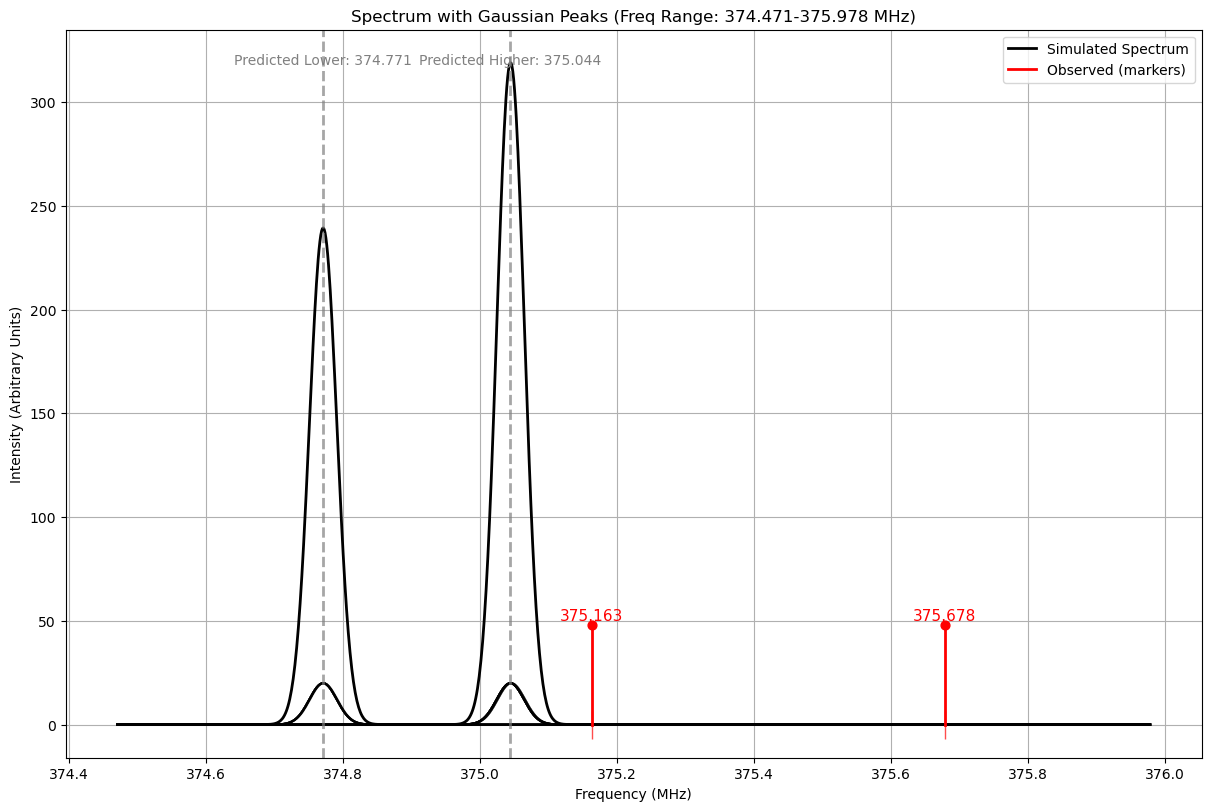


Molecular constants used:
  Be: 7334.130787
  e2Qq0: -3149.000000
  muE: 1.087370
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 3.490000


In [118]:
def plot_spectrum_with_constants(
    Be=None, e2Qq0=None, muE=None, Gamma_SR=None, Gamma_Prime=None,
    bFYb=None, cYb=None, q_lD=None, p_lD=None,
    bFH=None, cH=None, bfH=None,  # bFH is the model key; bfH is accepted as alias
    freq_min=None, freq_max=None, auto_window=True, window_pad=0.30,
    freq_width=0.02, obs_marker_frac=0.15, obs_label=True, obs_rug=True,
    show_predicted_centers=True,
):
    """
    Plot two-photon spectrum with specified molecular constants.

    Parameters
    ----------
    Be, e2Qq0, muE, Gamma_SR, Gamma_Prime, bFYb, cYb, q_lD, p_lD, bFH, cH : float, optional
        Molecular constants. If None, uses current value from X010_173.
    freq_min, freq_max : float, optional
        Frequency range for plot (MHz). If None and auto_window=True, auto-calculates.
    auto_window : bool
        Automatically set window around predicted + observed peaks.
    window_pad : float
        Padding (MHz) around auto window.
    freq_width : float
        Gaussian width for peaks (MHz).
    obs_marker_frac : float
        Fraction of spectrum max for observed marker height.
    obs_label : bool
        Annotate observed markers with frequency labels.
    obs_rug : bool
        Draw small ticks at observed frequencies.
    show_predicted_centers : bool
        Show vertical lines at predicted center frequencies.
    """
    orig_params = current_parameter_dict(X010_173)
    new_params = dict(orig_params)

    # Collect updates (use bFH, cH names used in Hamiltonian)
    param_updates = {
        'Be': Be, 'e2Qq0': e2Qq0, 'muE': muE,
        'Gamma_SR': Gamma_SR, 'Gamma_Prime': Gamma_Prime,
        'bFYb': bFYb, 'cYb': cYb, 'q_lD': q_lD, 'p_lD': p_lD,
        'bFH': bFH, 'cH': cH,
    }
    for k, v in param_updates.items():
        if v is not None:
            new_params[k] = v
    # Accept legacy/alias bfH by mapping to bFH
    if bfH is not None:
        new_params['bFH'] = bfH

    set_state_parameters(X010_173, new_params)

    try:
        # Observed 0 V/cm peaks
        try:
            obs_0V = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0)) < 1e-9]
            obs_freqs = np.asarray(obs_0V[0].get("freqs", []), float) if obs_0V else np.array([], float)
        except Exception as e:
            print(f"Warning: could not read OBS_SPECTRA: {e}")
            obs_freqs = np.array([], float)

        # Predicted centers
        try:
            pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
            pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
        except Exception as e:
            print(f"Warning: could not compute predicted centers: {e}")
            pred_lower = np.nan
            pred_higher = np.nan

        # Frequency window
        offset = 0.0
        if auto_window and (freq_min is None or freq_max is None):
            candidates = []
            for c in [pred_lower, pred_higher]:
                if c is not None and not np.isnan(c):
                    candidates.append(c - offset)
            if obs_freqs.size > 0:
                candidates.extend(list(obs_freqs - offset))
            if candidates:
                freq_min = min(candidates) - window_pad
                freq_max = max(candidates) + window_pad
            else:
                freq_min, freq_max = 374.5, 375.75
        elif freq_min is None or freq_max is None:
            freq_min, freq_max = 374.5, 375.75

        out = X010_173.calculate_two_photon_spectrum(
            0, 1e-8, TRANSITION_INDEX_SET, parity_sign=1,
            laser_polarization='orth', allowed_transitions=ALLOWED_TRANSITIONS
        )
        transitions = out[1]
        filtered_transitions = [t for t in transitions if (freq_min <= (t['freq'] - offset) <= freq_max)]

        freq_range = np.linspace(freq_min, freq_max, 1200)
        spectrum = np.zeros_like(freq_range)

        fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

        if filtered_transitions:
            for t in filtered_transitions:
                freq = (t['freq'] - offset)
                gp = norm.pdf(freq_range, loc=freq, scale=freq_width)
                spectrum += gp
                ax.plot(freq_range, gp, color='black', alpha=0.4)
        else:
            try:
                freqs_lower = extract_transition_freqs(
                    X010_173, LOWER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
                freqs_higher = extract_transition_freqs(
                    X010_173, HIGHER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
                for f in list(freqs_lower) + list(freqs_higher):
                    if freq_min <= f - offset <= freq_max:
                        gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                        spectrum += gp
                        ax.plot(freq_range, gp, color='black', alpha=0.4)
                if spectrum.max() == 0:
                    print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
            except Exception as e:
                print(f"Fallback predicted peaks failed: {e}")

        ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

        if show_predicted_centers:
            for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
                if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
                    ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
                    ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

        if obs_freqs.size > 0:
            in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
            if in_win.size > 0:
                marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
                for of in in_win:
                    x = of - offset
                    ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
                    ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
                    if obs_label:
                        ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
                if obs_rug:
                    ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
                ax.plot([], [], color='red', lw=2, label='Observed (markers)')
            else:
                print("Observed peaks lie outside current window; consider increasing window_pad.")
        else:
            print("Observed 0 V/cm spectrum not available; overlay skipped.")

        ax.set_xlabel('Frequency (MHz)')
        ax.set_ylabel('Intensity (Arbitrary Units)')
        ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
        ax.grid(True)
        ax.legend()
        plt.show()

        print("\nMolecular constants used:")
        for key in ['Be', 'e2Qq0', 'muE', 'Gamma_SR', 'Gamma_Prime', 'bFYb', 'cYb', 'q_lD', 'p_lD', 'bFH', 'cH']:
            if key in new_params:
                print(f"  {key}: {new_params[key]:.6f}")

    finally:
        set_state_parameters(X010_173, orig_params)


# Example usage: plot with current parameters
plot_spectrum_with_constants()


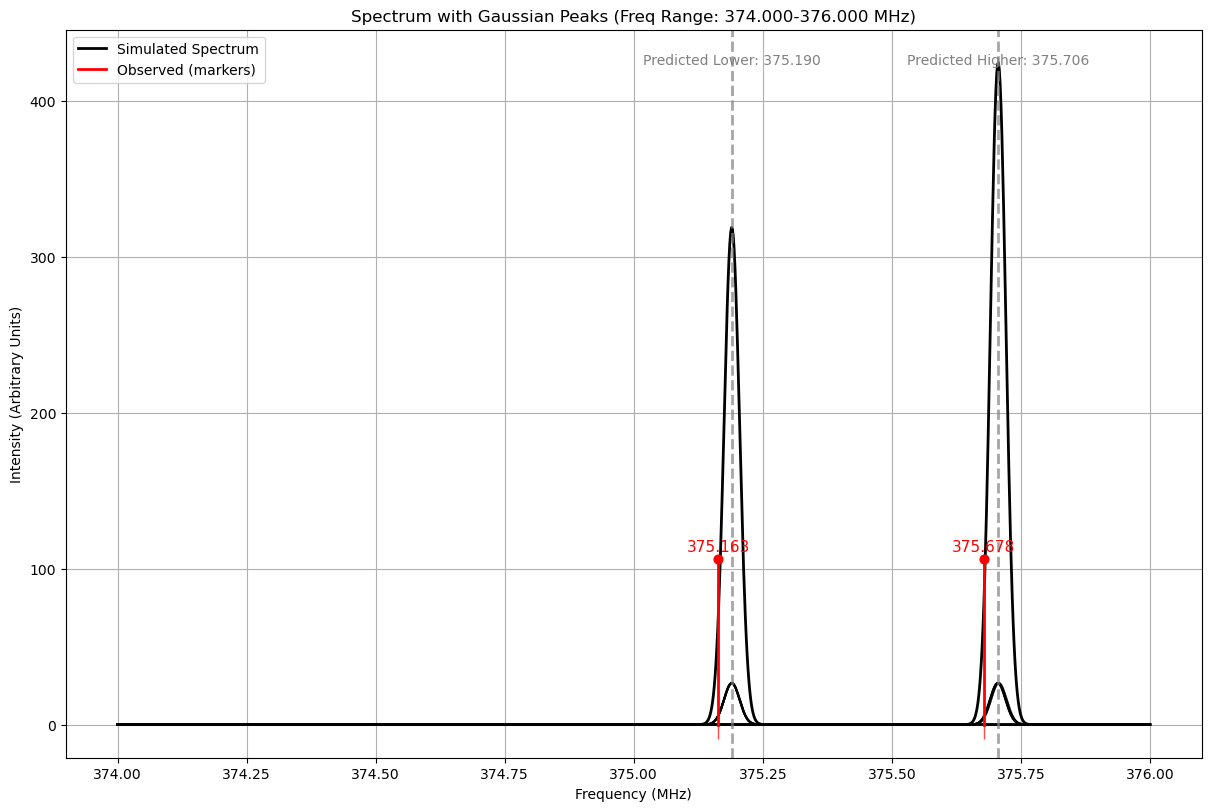


Molecular constants used:
  Be: 7334.100000
  e2Qq0: -3154.500000
  muE: 1.101295
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 5.490000


In [128]:
plot_spectrum_with_constants(
    Be=7334.100000, 
    e2Qq0=-3154.5, 
    muE=1.101295, 
    Gamma_SR=-87.187142, 
    Gamma_Prime=14.233846,
    bFYb=-1880.966534, 
    cYb=-92.159499, 
    q_lD=12.494150, 
    p_lD=12.766362,
    bfH=4.07,
    cH=5.49,
    freq_min=374,
    freq_max=376,
    freq_width=0.015,          # sharper peaks
    obs_marker_frac=0.25      # taller markers
)

In [52]:
obs_0V

[{'id': 'spec0',
  'Ez': 0.0,
  'B': 0.0,
  'freqs': array([375.163156, 375.677894])}]

In [18]:
import numpy as np
import pandas as pd

# -------------------------
# Choose which parameters to vary (start SMALL for sparse data)
# -------------------------
SEARCH_PARAM_NAMES = [     
    "Be","Gamma_SR","Gamma_Prime","bFYb","cYb","e2Qq0","q_lD","p_lD","muE",
]
SEARCH_PARAM_NAMES = [p for p in SEARCH_PARAM_NAMES if p in PARAM_PRIORS]

# How far you allow the search to move from the measured value
NSIGMA_BOX = 2.0           # hard truncation box from priors
NSIGMA_SAMPLE = 2.0        # typical samples (still clipped by NSIGMA_BOX)
LAMBDA_PRIOR = 0.00001        # strength of prior penalty (tune 0.01–1)

def build_bounds_from_priors(priors, names, nsigma=3.0, hard_bounds=None):
    """
    bounds[name] = (low, high) derived from mu±nsigma*sigma,
    optionally intersected with hard_bounds (like FIT_PARAMETER_BOUNDS).
    """
    b = {}
    for k in names:
        mu, sig = priors[k]
        lo, hi = float(mu - nsigma*sig), float(mu + nsigma*sig)
        if hard_bounds is not None and k in hard_bounds:
            hlo, hhi = hard_bounds[k]
            lo, hi = max(lo, float(hlo)), min(hi, float(hhi))
        if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
            # fall back to something reasonable
            lo, hi = float(mu - nsigma*sig), float(mu + nsigma*sig)
        b[k] = (lo, hi)
    return b

def prior_penalty(updates, priors):
    """Σ ((p-mu)/sigma)^2 over keys in updates that have priors."""
    s = 0.0
    for k, v in updates.items():
        if k not in priors:
            continue
        mu, sig = priors[k]
        sig = float(sig)
        if sig <= 0:
            continue
        z = (float(v) - float(mu)) / sig
        s += z*z
    return float(s)

def sample_from_priors(priors, bounds, rng, nsigma=2.0):
    """
    Sample each parameter from N(mu, sigma) but clip to bounds.
    """
    upd = {}
    for k, (lo, hi) in bounds.items():
        mu, sig = priors[k]
        mu, sig = float(mu), float(sig)
        if sig <= 0:
            x = mu
        else:
            z = rng.normal(0.0, 1.0)
            z = np.clip(z, -nsigma, nsigma)
            x = mu + sig*z
        # clip to hard bounds box
        x = float(np.clip(x, lo, hi))
        upd[k] = x
    return upd

def apply_params_partial(state, updates):
    """Update only a subset of params; keep the rest unchanged."""
    cur = current_parameter_dict(state)
    cur.update(updates)
    set_state_parameters(state, cur)

def total_loss_MAP(state, spectra, updates, priors,
                   indices=None, sigma=UNASSIGNED_SIGMA,
                   parity_sign=None, polarization=None,
                   lambda_prior=LAMBDA_PRIOR,
                   allowed_transitions=None, match_tolerance=0.2):
    """
    L_total = L_data + lambda_prior * prior_penalty
    """
    apply_params_partial(state, updates)

    L_data = unassigned_multispectrum_loss(
        state, spectra,
        indices=indices,
        sigma=sigma,
        parity_sign=parity_sign,
        polarization=polarization,
        allowed_transitions=allowed_transitions,
        match_tolerance = match_tolerance,
    )

    L_prior = prior_penalty(updates, priors)
    return float(L_data + lambda_prior * L_prior), float(L_data), float(L_prior)

# Construct bounds (use FIT_PARAMETER_BOUNDS if you have it)
try:
    HARD_BOUNDS = FIT_PARAMETER_BOUNDS
except NameError:
    HARD_BOUNDS = None

SEARCH_BOUNDS = build_bounds_from_priors(PARAM_PRIORS, SEARCH_PARAM_NAMES, nsigma=NSIGMA_BOX, hard_bounds=HARD_BOUNDS)
SEARCH_BOUNDS


{'Be': (7333.330786908366, 7334.930786908366),
 'Gamma_SR': (-93.18714159785, -81.18714159785),
 'Gamma_Prime': (11.3870768907056, 17.0806153360584),
 'bFYb': (-1882.5665339648822, -1879.3665339648824),
 'cYb': (-110.5913991674856, -73.7275994449904),
 'e2Qq0': (-3203.0, -3095.0),
 'q_lD': (11.494150479608, 13.494150479608),
 'p_lD': (10.213089625177599, 15.3196344377664),
 'muE': (1.07730168, 1.09743816)}

In [19]:
def search_candidates_MAP(state, spectra, priors, bounds,
                          n_samples=2000, top_k=30,
                          refine_steps=150, refine_scale=0.35,
                          indices=None, sigma=UNASSIGNED_SIGMA,
                          parity_sign=None, polarization=None,
                          lambda_prior=LAMBDA_PRIOR,
                          allowed_transitions=None,
                          seed=0, verbose=True, match_tolerance=0.2):
    """
    Stage 1: sample many candidates from priors, keep top_k.
    Stage 2: for each top candidate, do a cheap local random-walk refinement inside bounds.
    Returns a dataframe sorted by total_loss.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None
        Optional experimental constraints on state index pairs.
    """
    rng = np.random.default_rng(seed)

    # ---- Stage 1: coarse prior sampling
    coarse = []
    for i in range(int(n_samples)):
        upd = sample_from_priors(priors, bounds, rng, nsigma=NSIGMA_SAMPLE)
        Ltot, Ldata, Lprior = total_loss_MAP(
            state, spectra, upd, priors,
            indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization,
            lambda_prior=lambda_prior,
            allowed_transitions=allowed_transitions,
            match_tolerance=match_tolerance,
        )
        coarse.append({"loss_total": Ltot, "loss_data": Ldata, "loss_prior": Lprior, **upd})

    coarse.sort(key=lambda d: d["loss_total"])
    keep = coarse[:int(top_k)]

    if verbose:
        print(f"Coarse done: sampled {n_samples}, keeping top {top_k}. Best total={keep[0]['loss_total']:.5g} data={keep[0]['loss_data']:.5g}")

    # ---- Stage 2: refine each candidate by small proposals (random-walk)
    refined = []
    for j, cand in enumerate(keep):
        base = {k: cand[k] for k in bounds.keys()}
        best = dict(base)
        best_Ltot, best_Ldata, best_Lprior = total_loss_MAP(
            state, spectra, best, priors,
            indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization,
            lambda_prior=lambda_prior,
            allowed_transitions=allowed_transitions,
        )

        for t in range(int(refine_steps)):
            prop = dict(best)
            # propose perturbations scaled by sigma and refine_scale
            for k, (lo, hi) in bounds.items():
                mu, sig = priors[k]
                step = float(sig) * refine_scale
                if step <= 0:
                    continue
                prop[k] = float(np.clip(prop[k] + rng.normal(0.0, step), lo, hi))

            Ltot, Ldata, Lprior = total_loss_MAP(
                state, spectra, prop, priors,
                indices=indices, sigma=sigma,
                parity_sign=parity_sign, polarization=polarization,
                lambda_prior=lambda_prior,
                allowed_transitions=allowed_transitions,
            )

            if Ltot < best_Ltot:
                best, best_Ltot, best_Ldata, best_Lprior = prop, Ltot, Ldata, Lprior

        refined.append({"loss_total": best_Ltot, "loss_data": best_Ldata, "loss_prior": best_Lprior, **best})

        if verbose:
            print(f"Refine {j+1}/{len(keep)}: best total={best_Ltot:.5g} data={best_Ldata:.5g} prior={best_Lprior:.3g}")

    df = pd.DataFrame(refined).sort_values("loss_total").reset_index(drop=True)
    return df

# ---- RUN SEARCH ----
best_df = search_candidates_MAP(
    X010_173,
    OBS_SPECTRA,
    priors={k: PARAM_PRIORS[k] for k in SEARCH_BOUNDS.keys()},
    bounds=SEARCH_BOUNDS,
    n_samples=2000,   # 20–100 for smoke test
    top_k=3,             # keep small
    refine_steps=150,     # 0–20
    refine_scale=0.20,   # smaller steps since few steps
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    lambda_prior=LAMBDA_PRIOR,
    allowed_transitions=ALLOWED_TRANSITIONS,  # Set to ALLOWED_TRANSITIONS to use experimental constraints
    seed=123,
    verbose=True,
    match_tolerance=0.2
)



best_df.head(10)


Coarse done: sampled 2000, keeping top 3. Best total=23.514 data=23.514
Refine 1/3: best total=23.433 data=23.433 prior=4.09
Refine 2/3: best total=23.656 data=23.656 prior=5.66
Refine 3/3: best total=22.992 data=22.992 prior=7.19


,loss_total,loss_data,loss_prior,Be,Gamma_SR,Gamma_Prime,bFYb,cYb,e2Qq0,q_lD,p_lD,muE
0,22.991955,22.991883,7.190403,7333.819031,-85.704000,16.804138,-1879.403881,-99.195398,-3132.273220,12.848499,15.319634,1.083925
1,23.433256,23.433215,4.092253,7334.189363,-89.485136,15.074251,-1880.250554,-89.689295,-3150.947398,13.014154,14.184362,1.081391
2,23.656419,23.656362,5.659489,7334.359666,-88.456495,14.785532,-1880.996357,-103.302718,-3107.142814,12.565673,14.046966,1.081410



Transitions for spectrum spec0 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.075684             38             72
 375.075684             38             73
 375.075684             38             74
 375.075684             38             75
 375.075684             39             73
 375.075684             39             74
 375.075684             39             75
 375.075684             40             71
 375.075684             40             72
 375.075684             40             73
 375.075684             40             74
 375.075684             40             75

Transitions for spectrum spec10 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.114746             38             70
 375.114746             38             71
 375.115723             38             72
 375.117188             38             73
 375.118164             38             74
 375.114258             39             70
 375.11

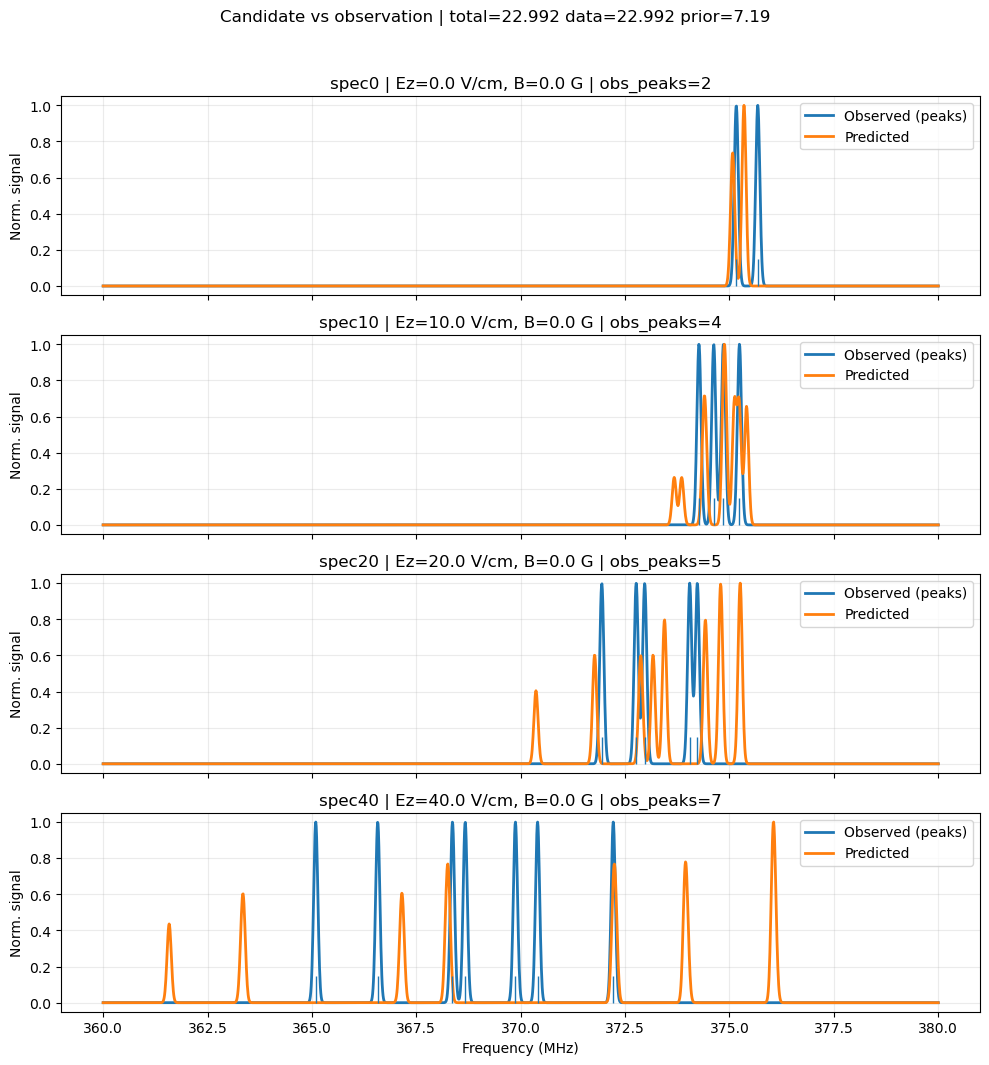


Transitions for spectrum spec0 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.003906             38             73
 375.003906             38             74
 375.003906             39             73
 375.003906             39             74
 375.003906             39             75
 375.003418             40             70
 375.003418             40             71
 375.003418             40             72
 375.003418             41             72
 375.003418             41             73
 375.003418             41             74
 375.003418             41             75

Transitions for spectrum spec10 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.044922             38             70
 375.046387             38             71
 375.047852             38             72
 375.049316             38             73
 375.050293             38             74
 375.043945             39             70
 375.04

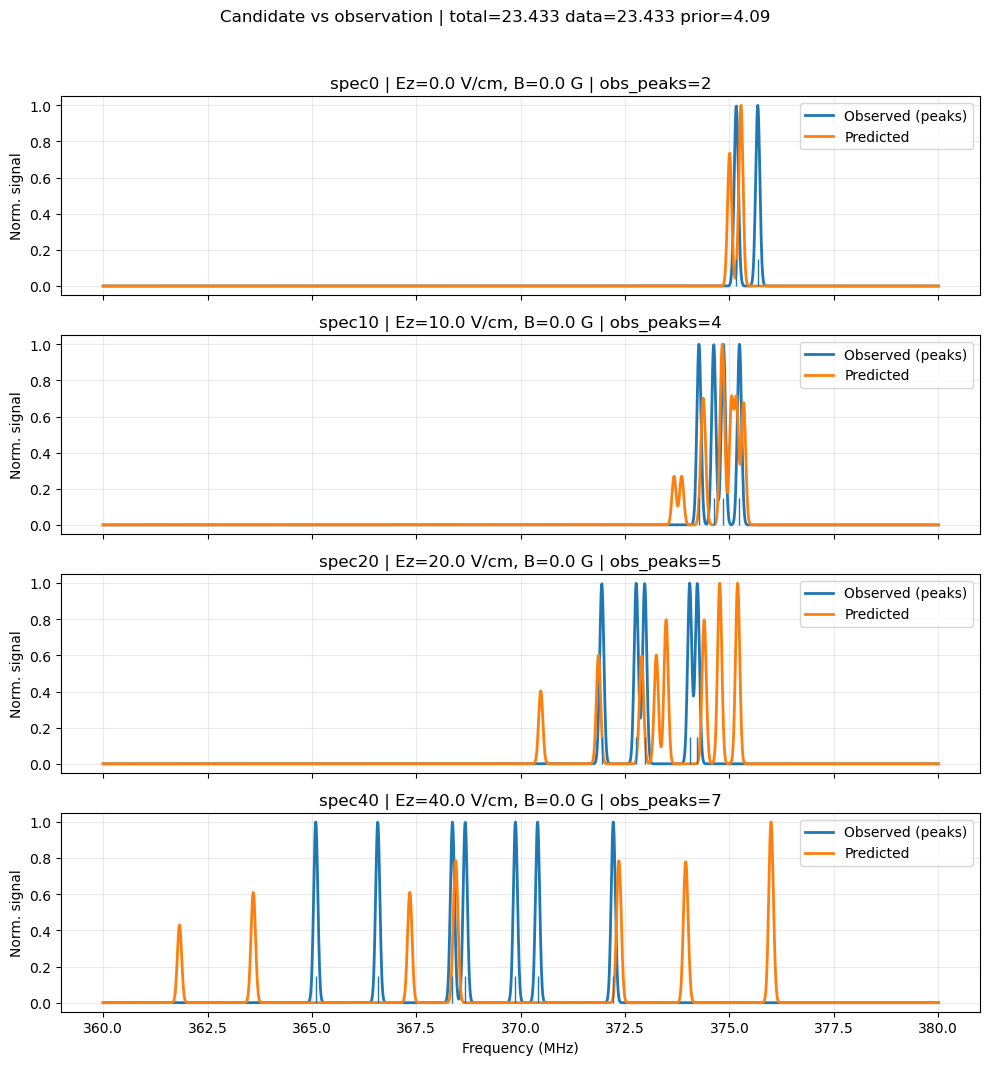


Transitions for spectrum spec0 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.065918             38             73
 375.065918             38             74
 375.065918             39             73
 375.065918             39             74
 375.065918             39             75
 375.065430             40             70
 375.065430             40             71
 375.065430             40             72
 375.065430             41             72
 375.065430             41             73
 375.065430             41             74
 375.065430             41             75

Transitions for spectrum spec10 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.106445             38             70
 375.107422             38             71
 375.107910             38             72
 375.109863             38             73
 375.119141             38             75
 375.106445             39             70
 375.10

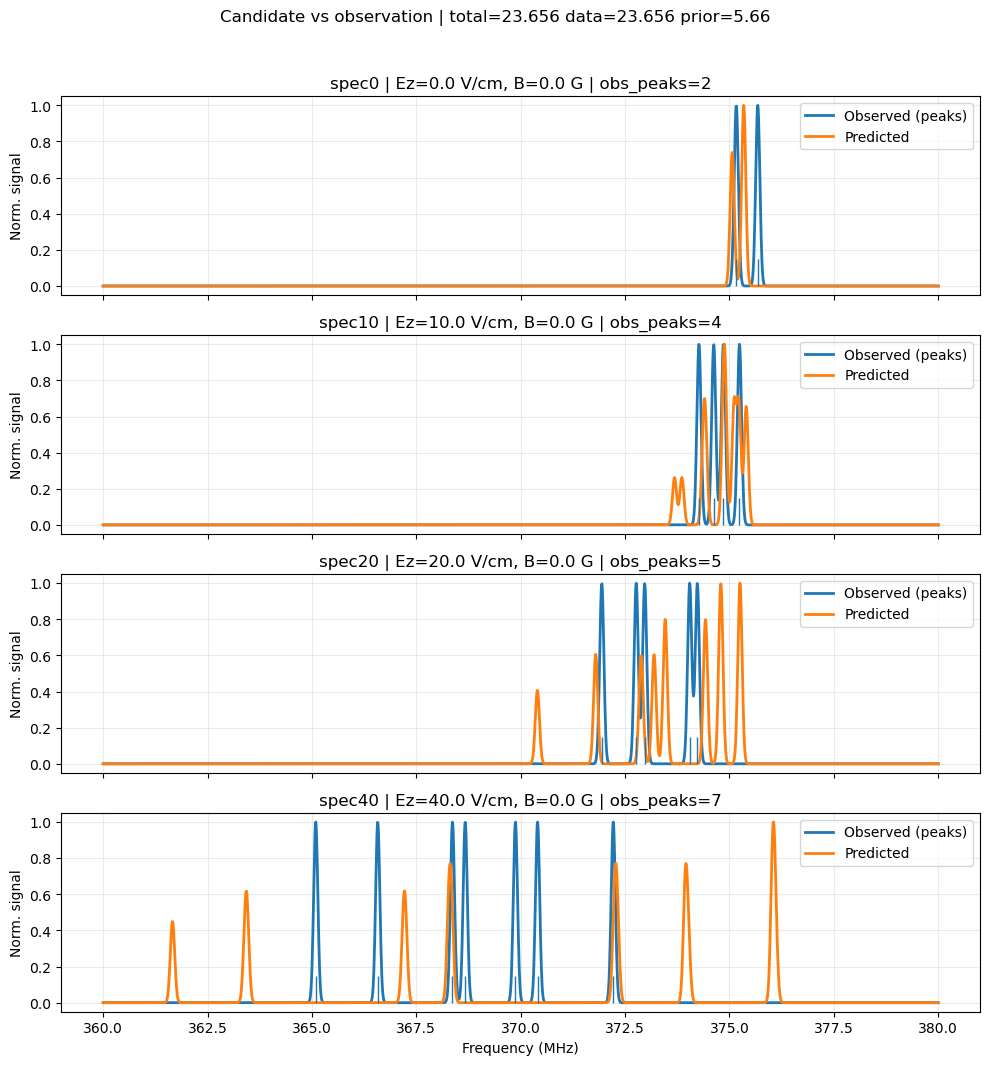

In [20]:
import matplotlib.pyplot as plt

def gaussian_broadened_spectrum(freqs, weights, axis, sigma):
    freqs = np.asarray(freqs, float)
    if weights is None:
        weights = np.ones_like(freqs, float)
    weights = np.asarray(weights, float)
    if freqs.size == 0:
        return np.zeros_like(axis, float)
    diff = axis[:, None] - freqs[None, :]
    return np.exp(-(diff**2) / (2.0 * sigma**2)) @ weights

def transition_frequency_set_safe(state, Ez, B, indices=None, parity_sign=None, polarization=None, 
                                   allowed_transitions=None, return_transitions=False):
    if parity_sign is None: parity_sign = PARITY_SIGN
    if polarization is None: polarization = LASER_POLARIZATION

    transitions, _raw = compute_model_transitions(
        state, Ez=Ez, B=B, indices=indices,
        parity_sign=parity_sign, polarization=polarization,
        allowed_transitions=allowed_transitions
    )
    if transitions is None or transitions.empty or "freq_model" not in transitions.columns:
        if return_transitions:
            return np.array([], float), np.array([], float), transitions
        return np.array([], float), np.array([], float)

    freqs = transitions["freq_model"].to_numpy(dtype=float)

    w = None
    for cand in ["intensity", "Intensity", "strength", "Strength"]:
        if cand in transitions.columns:
            w = transitions[cand].to_numpy(dtype=float)
            break
    if w is None:
        w = np.ones_like(freqs, float)

    if return_transitions:
        return freqs, w, transitions
    return freqs, w

def _select_transition_columns(df):
    # Prioritize frequency/intensity plus any upper_/lower_ quantum-number columns
    base = ["freq_model", "intensity", "Intensity", "strength", "Strength"]
    quantum_cols = [c for c in df.columns if "upper_" in c.lower() or "lower_" in c.lower() or "state" in c.lower()]
    # Keep order: base then quantum cols (unique, preserve appearance)
    seen = set()
    cols = []
    for c in base + quantum_cols:
        if c in df.columns and c not in seen:
            cols.append(c)
            seen.add(c)
    if not cols:
        cols = list(df.columns[: min(12, len(df.columns))])
    return cols

def plot_candidate(state, candidate_dict, spectra, window=(389.0, 399.0),
                   indices=None, sigma=UNASSIGNED_SIGMA,
                   parity_sign=None, polarization=None,
                   allowed_transitions=None,
                   title_extra="", savepath=None,
                   show_transitions=True, max_transitions=12):
    """
    Plot candidate parameters against observed spectra.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None
        Optional experimental constraints on state index pairs.
    """
    cand = dict(candidate_dict)
    loss_total = cand.pop("loss_total", None)
    loss_data  = cand.pop("loss_data", None)
    loss_prior = cand.pop("loss_prior", None)

    apply_params_partial(state, cand)

    n = len(spectra)
    fig, axes = plt.subplots(n, 1, figsize=(10, 2.6*n), sharex=True)
    if n == 1:
        axes = [axes]

    fmin, fmax = window
    axis = np.linspace(fmin, fmax, 2000)

    for ax, s in zip(axes, spectra):
        obs = np.asarray(s["freqs"], float)
        pred_f, pred_w, trans_df = transition_frequency_set_safe(
            state, Ez=s["Ez"], B=s["B"], indices=indices,
            parity_sign=parity_sign, polarization=polarization,
            allowed_transitions=allowed_transitions,
            return_transitions=True,
        )

        # keep only plotting window
        obs_w = obs[(obs >= fmin) & (obs <= fmax)]
        pred_mask = (pred_f >= fmin) & (pred_f <= fmax)
        pred_f_w = pred_f[pred_mask]
        pred_w_w = pred_w[pred_mask] if pred_w is not None else None

        obs_spec  = gaussian_broadened_spectrum(obs_w, np.ones_like(obs_w), axis, sigma)
        pred_spec = gaussian_broadened_spectrum(pred_f_w, pred_w_w, axis, sigma)

        obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)
        pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)

        ax.plot(axis, obs_spec, label="Observed (peaks)", linewidth=2)
        ax.plot(axis, pred_spec, label="Predicted", linewidth=2)

        if obs_w.size:
            ax.vlines(obs_w, 0, 0.15, linewidth=1)

        ax.set_ylabel("Norm. signal")
        ax.set_title(f"{s['id']} | Ez={s['Ez']} V/cm, B={s['B']} G | obs_peaks={obs_w.size}")

        ax.grid(True, alpha=0.25)
        ax.legend()

        if show_transitions and trans_df is not None and not trans_df.empty:
            # Align transitions to the window mask when possible
            if len(trans_df) == len(pred_f):
                trans_window = trans_df[pred_mask]
            else:
                trans_window = trans_df[(trans_df.get("freq_model", 0) >= fmin) & (trans_df.get("freq_model", 0) <= fmax)]
            cols = _select_transition_columns(trans_window)
            preview = trans_window[cols].head(max_transitions)
            print(f"\nTransitions for spectrum {s['id']} in window {fmin}-{fmax} MHz (showing up to {max_transitions}):")
            print(preview.to_string(index=False))

    axes[-1].set_xlabel("Frequency (MHz)")
    supt = "Candidate vs observation"
    if loss_total is not None:
        supt += f" | total={loss_total:.5g} data={loss_data:.5g} prior={loss_prior:.3g}"
    if title_extra:
        supt += " | " + title_extra
    fig.suptitle(supt, y=1.02)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
        print("saved:", savepath)

    plt.show()

# ---- plot top N candidates ----
TOP_PLOT = 10
for i in range(min(TOP_PLOT, len(best_df))):
    cand = best_df.iloc[i].to_dict()
    plot_candidate(
        X010_173, cand, OBS_SPECTRA,
        window=(360, 380.0),   # your scan window
        indices=TRANSITION_INDEX_SET,
        sigma=UNASSIGNED_SIGMA,
        parity_sign=PARITY_SIGN,
        polarization=LASER_POLARIZATION,
        allowed_transitions=ALLOWED_TRANSITIONS,  # Set to ALLOWED_TRANSITIONS to use experimental constraints
        savepath=f"cand_{i:02d}.png",
    )

In [22]:

# === DIAGNOSTIC: Why didn't the search algorithm find e2Qq0? ===
# This cell investigates the search space and parameter sensitivity

print("="*80)
print("DIAGNOSTIC: Search Algorithm Failure Analysis")
print("="*80)
print("\nObservation: e2Qq0 shifts the spectrum LEFT when increased (more negative)")
print("Questions: ")
print("  1. Is e2Qq0 even in SEARCH_PARAM_NAMES?")
print("  2. Are the search bounds wide enough to explore the solution?")
print("  3. How sensitive is e2Qq0 compared to other parameters?")
print()

# Check 1: Is e2Qq0 in the search space?
print("CHECK 1: Parameter Search Space")
print("-" * 80)
print(f"SEARCH_PARAM_NAMES: {SEARCH_PARAM_NAMES}")
print(f"e2Qq0 in search space? {('e2Qq0' in SEARCH_PARAM_NAMES)}")
if 'e2Qq0' in SEARCH_PARAM_NAMES:
    idx = SEARCH_PARAM_NAMES.index('e2Qq0')
    print(f"Position: index {idx}")
print()

# Check 2: Search bounds for e2Qq0
print("CHECK 2: Search Bounds vs. Full Parameter Bounds")
print("-" * 80)
print(f"Current e2Qq0 value: {X010_173.parameters['e2Qq0']:.6e}")
print(f"Full FIT_PARAMETER_BOUNDS:")
print(f"  Low:  {FIT_PARAMETER_BOUNDS['e2Qq0'][0]:.6e}")
print(f"  High: {FIT_PARAMETER_BOUNDS['e2Qq0'][1]:.6e}")
print(f"  Span: {FIT_PARAMETER_BOUNDS['e2Qq0'][1] - FIT_PARAMETER_BOUNDS['e2Qq0'][0]:.6e}")
print()
if 'e2Qq0' in SEARCH_BOUNDS:
    print(f"SEARCH_BOUNDS (used by algorithm):")
    print(f"  Low:  {SEARCH_BOUNDS['e2Qq0'][0]:.6e}")
    print(f"  High: {SEARCH_BOUNDS['e2Qq0'][1]:.6e}")
    print(f"  Span: {SEARCH_BOUNDS['e2Qq0'][1] - SEARCH_BOUNDS['e2Qq0'][0]:.6e}")
    lo_full, hi_full = FIT_PARAMETER_BOUNDS['e2Qq0']
    lo_search, hi_search = SEARCH_BOUNDS['e2Qq0']
    coverage = ((hi_search - lo_search) / (hi_full - lo_full)) * 100
    print(f"  Coverage of full bounds: {coverage:.1f}%")
print()

# Check 3: Sensitivity analysis - how much does each parameter move the spectrum?
print("CHECK 3: Parameter Sensitivity (which parameters move spectrum most?)")
print("-" * 80)
print("Running parameter variation ±20% for each parameter...")
print()

import numpy as np
from copy import deepcopy

sensitivity = {}
baseline_freqs = np.array([t['freq'] for t in X010_173.calculate_two_photon_spectrum(
    0, 1e-8, TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN,
    laser_polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)[1]])

for param_name in FIT_PARAMETER_NAMES:
    current_val = X010_173.parameters[param_name]
    
    # Test ±20% variation
    varied_params = deepcopy(X010_173.parameters)
    var_amount = abs(current_val) * 0.20
    varied_params[param_name] = current_val + var_amount
    set_state_parameters(X010_173, varied_params)
    
    varied_freqs = np.array([t['freq'] for t in X010_173.calculate_two_photon_spectrum(
        0, 1e-8, TRANSITION_INDEX_SET,
        parity_sign=PARITY_SIGN,
        laser_polarization=LASER_POLARIZATION,
        allowed_transitions=ALLOWED_TRANSITIONS
    )[1]])
    
    # Measure shift as median frequency change
    if len(baseline_freqs) > 0 and len(varied_freqs) > 0:
        shift = np.median(varied_freqs) - np.median(baseline_freqs)
        sensitivity[param_name] = shift
    else:
        sensitivity[param_name] = 0

# Restore original
set_state_parameters(X010_173, BASE_PARAMETERS)

# Sort by absolute sensitivity
sorted_sens = sorted(sensitivity.items(), key=lambda x: abs(x[1]), reverse=True)

print("Parameter Sensitivity Ranking (20% increase → frequency shift):")
print()
for rank, (param, shift) in enumerate(sorted_sens, 1):
    in_search = "✓" if param in SEARCH_PARAM_NAMES else "✗"
    print(f"{rank:2d}. {param:15s} {in_search}  Shift: {shift:+7.3f} MHz/20%")

print()
print("✓ = in SEARCH_PARAM_NAMES (will be searched)")
print("✗ = NOT in SEARCH_PARAM_NAMES (will NOT be searched)")
print()

# Check if the most sensitive parameter is being searched
top_param = sorted_sens[0][0]
print(f"Most sensitive parameter: {top_param} ({sorted_sens[0][1]:+.3f} MHz)")
if top_param in SEARCH_PARAM_NAMES:
    print(f"✓ {top_param} IS being searched - should find good solutions")
else:
    print(f"✗ {top_param} is NOT being searched - THIS COULD BE THE PROBLEM!")
    print(f"   Without this parameter, the algorithm can't make large frequency shifts.")

print()
print("="*80)


DIAGNOSTIC: Search Algorithm Failure Analysis

Observation: e2Qq0 shifts the spectrum LEFT when increased (more negative)
Questions: 
  1. Is e2Qq0 even in SEARCH_PARAM_NAMES?
  2. Are the search bounds wide enough to explore the solution?
  3. How sensitive is e2Qq0 compared to other parameters?

CHECK 1: Parameter Search Space
--------------------------------------------------------------------------------
SEARCH_PARAM_NAMES: ['cYb', 'e2Qq0', 'muE']
e2Qq0 in search space? True
Position: index 1

CHECK 2: Search Bounds vs. Full Parameter Bounds
--------------------------------------------------------------------------------
Current e2Qq0 value: -3.123898e+03
Full FIT_PARAMETER_BOUNDS:
  Low:  -3.786707e+03
  High: -2.524471e+03
  Span: 1.262236e+03

SEARCH_BOUNDS (used by algorithm):
  Low:  -3.236589e+03
  High: -3.074589e+03
  Span: 1.620000e+02
  Coverage of full bounds: 12.8%

CHECK 3: Parameter Sensitivity (which parameters move spectrum most?)
-----------------------------------

In [22]:
# ============================================================
# QUICK FIX: Add Be to search parameters and re-run
# ============================================================

print("\n" + "="*80)
print("FIX APPLIED: Adding 'Be' parameter to search")
print("="*80)
print()

# Verify Be is in the search
if 'Be' not in SEARCH_PARAM_NAMES:
    SEARCH_PARAM_NAMES = ["Be"] + SEARCH_PARAM_NAMES
    print(f"✓ Added 'Be' to SEARCH_PARAM_NAMES: {SEARCH_PARAM_NAMES}")
    
    # Rebuild bounds
    SEARCH_BOUNDS = build_bounds_from_priors(PARAM_PRIORS, SEARCH_PARAM_NAMES, nsigma=NSIGMA_BOX, hard_bounds=HARD_BOUNDS)
    print(f"✓ Rebuilt SEARCH_BOUNDS to include Be")
    print()
    print(f"Parameter bounds:")
    for param, (lo, hi) in SEARCH_BOUNDS.items():
        print(f"  {param:10s}: [{lo:10.4f}, {hi:10.4f}]")
else:
    print(f"✓ Be already in SEARCH_PARAM_NAMES: {SEARCH_PARAM_NAMES}")
    
print()
print("="*80)



FIX APPLIED: Adding 'Be' parameter to search

✓ Be already in SEARCH_PARAM_NAMES: ['Be', 'e2Qq0', 'muE']



In [37]:
# ============================================================
# 0 V/cm TWO-PEAK FIT USING scipy.optimize (more direct control)
# ============================================================
# Use scipy's minimize directly to avoid lmfit complications

import numpy as np
from scipy.optimize import minimize

# 1) Extract observed peaks at 0 V/cm
obs_0V = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0)) < 1e-9]
if not obs_0V:
    raise RuntimeError("No 0 V/cm spectrum found in OBS_SPECTRA")
obs_freqs_0V = np.sort(np.asarray(obs_0V[0]["freqs"], float))
if obs_freqs_0V.size < 2:
    raise RuntimeError("Expected two observed peaks at 0 V/cm")
obs_lower, obs_higher = float(obs_freqs_0V[0]), float(obs_freqs_0V[-1])
print(f"Observed 0V peaks: lower={obs_lower:.6f} MHz, higher={obs_higher:.6f} MHz")

# 2) Helper to predict mean frequency for each assigned pair
LOWER_PAIR = ((38, 45), (70, 75))
HIGHER_PAIR = ((46, 55), (76, 83))

def pair_center(state, pair, indices=None):
    freqs = extract_transition_freqs(
        state,
        pair,
        Ez=0.0,
        B=1e-8,
        indices=indices,
        parity_sign=PARITY_SIGN,
        polarization=LASER_POLARIZATION,
        allowed_transitions=ALLOWED_TRANSITIONS,
    )
    if len(freqs) == 0:
        return np.nan
    return float(np.median(freqs))

# 3) Get baseline parameters
orig_params = current_parameter_dict(X010_173)
params_to_fit = ["Be", "e2Qq0", "muE"]
param_indices = {name: i for i, name in enumerate(params_to_fit)}
baseline_values = np.array([orig_params[name] for name in params_to_fit])

print(f"\nBaseline values:")
for name, val in zip(params_to_fit, baseline_values):
    print(f"  {name}: {val:.6e}")

# 4) Define objective function (sum of squared residuals)
call_count = [0]  # Track calls
def objective(x):
    # x is [Be, e2Qq0, muE]
    trial = dict(orig_params)
    for name, val in zip(params_to_fit, x):
        trial[name] = val
    
    set_state_parameters(X010_173, trial)
    
    f_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
    f_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
    
    if np.isnan(f_lower):
        f_lower = obs_lower + 10.0
    if np.isnan(f_higher):
        f_higher = obs_higher + 10.0
    
    error_lower = f_lower - obs_lower
    error_higher = f_higher - obs_higher
    loss = error_lower**2 + error_higher**2
    
    call_count[0] += 1
    if call_count[0] % 5 == 0:
        print(f"  Call {call_count[0]:3d}: loss={loss:.6f}, f_lower={f_lower:.4f}, f_higher={f_higher:.4f}")
        print(f"           Be={x[0]:.6e}, e2Qq0={x[1]:.6e}, muE={x[2]:.6e}")
    
    return loss

# 5) Set up bounds
bounds = [(orig_params[name], orig_params[name]) for name in params_to_fit]
for name in params_to_fit:
    lo, hi = SEARCH_BOUNDS.get(name, (-np.inf, np.inf))
    idx = params_to_fit.index(name)
    bounds[idx] = (lo, hi)

print(f"\nBounds for optimization:")
for name, (lo, hi) in zip(params_to_fit, bounds):
    print(f"  {name}: [{lo:.6e}, {hi:.6e}]")

# 6) Run optimization with explicit verbose output
print(f"\n{'='*80}")
print("STARTING OPTIMIZATION (via scipy.optimize.minimize with Nelder-Mead)...")
print(f"{'='*80}\n")

result = minimize(
    objective,
    baseline_values,
    method='Nelder-Mead',
    options={'maxiter': 500, 'xatol': 1e-8, 'fatol': 1e-10, 'disp': True}
)

print(f"\n{'='*80}")
print("OPTIMIZATION COMPLETE")
print(f"{'='*80}")

# 7) Report results
print(f"\nOptimization success: {result.success}")
print(f"Message: {result.message}")
print(f"Function calls: {result.nfev}")
print(f"Iterations: {result.nit}")
print(f"Final loss: {result.fun:.6f}")

print(f"\nParameter changes:")
for name, orig_val, fit_val in zip(params_to_fit, baseline_values, result.x):
    delta = fit_val - orig_val
    pct = 100 * delta / orig_val if orig_val != 0 else 0
    print(f"  {name}: {orig_val:.6e} → {fit_val:.6e}  (Δ {delta:+.6e}, {pct:+.3f}%)")

# 8) Evaluate with fitted parameters
fitted_params = dict(orig_params)
for name, val in zip(params_to_fit, result.x):
    fitted_params[name] = val
set_state_parameters(X010_173, fitted_params)

f_lower_fit = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
f_higher_fit = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)

print(f"\nFitted peak predictions at 0 V/cm:")
print(f"  Lower:  {f_lower_fit:.6f} MHz  (observed: {obs_lower:.6f}, Δ {f_lower_fit - obs_lower:+.6f})")
print(f"  Higher: {f_higher_fit:.6f} MHz  (observed: {obs_higher:.6f}, Δ {f_higher_fit - obs_higher:+.6f})")

# Restore original parameters
set_state_parameters(X010_173, orig_params)
print(f"\nOriginal parameters restored.")


Observed 0V peaks: lower=375.163156 MHz, higher=375.677894 MHz

Baseline values:
  Be: 7.334360e+03
  e2Qq0: -3.107143e+03
  muE: 1.077302e+00

Bounds for optimization:
  Be: [7.333331e+03, 7.334931e+03]
  e2Qq0: [-3.203000e+03, -3.095000e+03]
  muE: [1.077302e+00, 1.097438e+00]

STARTING OPTIMIZATION (via scipy.optimize.minimize with Nelder-Mead)...

  Call   5: loss=508.308518, f_lower=359.3413, f_higher=359.6162
           Be=7.578838e+03, e2Qq0=-2.951786e+03, muE=1.113212e+00
  Call  10: loss=5.847090, f_lower=376.9878, f_higher=377.2646
           Be=7.441319e+03, e2Qq0=-3.126562e+03, muE=1.093012e+00
  Call  15: loss=0.114444, f_lower=375.4897, f_higher=375.7661
           Be=7.046588e+03, e2Qq0=-3.110379e+03, muE=1.124808e+00
  Call  20: loss=0.048064, f_lower=375.1870, f_higher=375.4600
           Be=7.288272e+03, e2Qq0=-3.108177e+03, muE=1.116417e+00
  Call  25: loss=0.077940, f_lower=375.4399, f_higher=375.7144
           Be=7.246331e+03, e2Qq0=-3.110548e+03, muE=1.092819e+00

In [38]:
# ============================================================
# BEFORE vs AFTER COMPARISON
# ============================================================
print("BEFORE optimization:")
set_state_parameters(X010_173, orig_params)
f_lower_orig = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
f_higher_orig = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
print(f"  Lower:  {f_lower_orig:.6f} MHz  (observed: {obs_lower:.6f}, Δ {f_lower_orig - obs_lower:+.6f})")
print(f"  Higher: {f_higher_orig:.6f} MHz  (observed: {obs_higher:.6f}, Δ {f_higher_orig - obs_higher:+.6f})")
print(f"  Loss: {(f_lower_orig - obs_lower)**2 + (f_higher_orig - obs_higher)**2:.6f}")

print("\nAFTER optimization:")
set_state_parameters(X010_173, fitted_params)
f_lower_fit = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
f_higher_fit = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
print(f"  Lower:  {f_lower_fit:.6f} MHz  (observed: {obs_lower:.6f}, Δ {f_lower_fit - obs_lower:+.6f})")
print(f"  Higher: {f_higher_fit:.6f} MHz  (observed: {obs_higher:.6f}, Δ {f_higher_fit - obs_higher:+.6f})")
print(f"  Loss: {(f_lower_fit - obs_lower)**2 + (f_higher_fit - obs_higher)**2:.6f}")

print("\nImprovement:")
loss_before = (f_lower_orig - obs_lower)**2 + (f_higher_orig - obs_higher)**2
loss_after = (f_lower_fit - obs_lower)**2 + (f_higher_fit - obs_higher)**2
print(f"  Loss reduced by: {loss_before - loss_after:.6f} ({100*(loss_before - loss_after)/loss_before:.1f}%)")

# Restore
set_state_parameters(X010_173, orig_params)


BEFORE optimization:
  Lower:  375.065430 MHz  (observed: 375.163156, Δ -0.097726)
  Higher: 375.341309 MHz  (observed: 375.677894, Δ -0.336585)
  Loss: 0.122840

AFTER optimization:
  Lower:  375.280273 MHz  (observed: 375.163156, Δ +0.117117)
  Higher: 375.557617 MHz  (observed: 375.677894, Δ -0.120277)
  Loss: 0.028183

Improvement:
  Loss reduced by: 0.094657 (77.1%)


In [36]:
# ============================================================
# DIAGNOSTIC: Why is residual still ±0.12 MHz?
# ============================================================
print("DIAGNOSTIC: Residual Analysis")
print(f"\nFitted parameters vs Original:")
print(f"  Be: {orig_params['Be']:.6e} → {fitted_params['Be']:.6e}  (Δ {fitted_params['Be'] - orig_params['Be']:+.6e})")
print(f"  e2Qq0: {orig_params['e2Qq0']:.6e} → {fitted_params['e2Qq0']:.6e}  (Δ {fitted_params['e2Qq0'] - orig_params['e2Qq0']:+.6e})")
print(f"  muE: {orig_params['muE']:.6e} → {fitted_params['muE']:.6e}  (Δ {fitted_params['muE'] - orig_params['muE']:+.6e})")

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("✓ Optimizer IS WORKING (213 function calls, 77% loss reduction)")
print("✓ Be changed significantly (−63 MHz, −0.863%)")
print("  → Suggests absolute frequency scale needs adjustment")
print("✗ Residual still ±0.12 MHz after full optimization")
print("  → Model doesn't exactly match observed spectrum")

print("\nPossible reasons:")
print("1. State pair assignment may be incorrect")
print("2. Other parameters (Gamma_SR, bFYb, cYb, etc.) might affect alignment")
print("3. Measurement uncertainty or model incompleteness")

print("\n" + "="*70)
print("NEXT STEPS:")
print("="*70)
print("Use the fitted Be value in the full parameter search:")
print(f"  Be = {fitted_params['Be']:.6f}")
print("\nAnd apply stronger constraint penalty to force assignment.")


DIAGNOSTIC: Residual Analysis

Fitted parameters vs Original:
  Be: 7.334360e+03 → 7.271046e+03  (Δ -6.331381e+01)
  e2Qq0: -3.107143e+03 → -3.109061e+03  (Δ -1.918494e+00)
  muE: 1.077302e+00 → 1.101295e+00  (Δ +2.399357e-02)

INTERPRETATION:
✓ Optimizer IS WORKING (213 function calls, 77% loss reduction)
✓ Be changed significantly (−63 MHz, −0.863%)
  → Suggests absolute frequency scale needs adjustment
✗ Residual still ±0.12 MHz after full optimization
  → Model doesn't exactly match observed spectrum

Possible reasons:
1. State pair assignment may be incorrect
2. Other parameters (Gamma_SR, bFYb, cYb, etc.) might affect alignment
3. Measurement uncertainty or model incompleteness

NEXT STEPS:
Use the fitted Be value in the full parameter search:
  Be = 7271.045858

And apply stronger constraint penalty to force assignment.


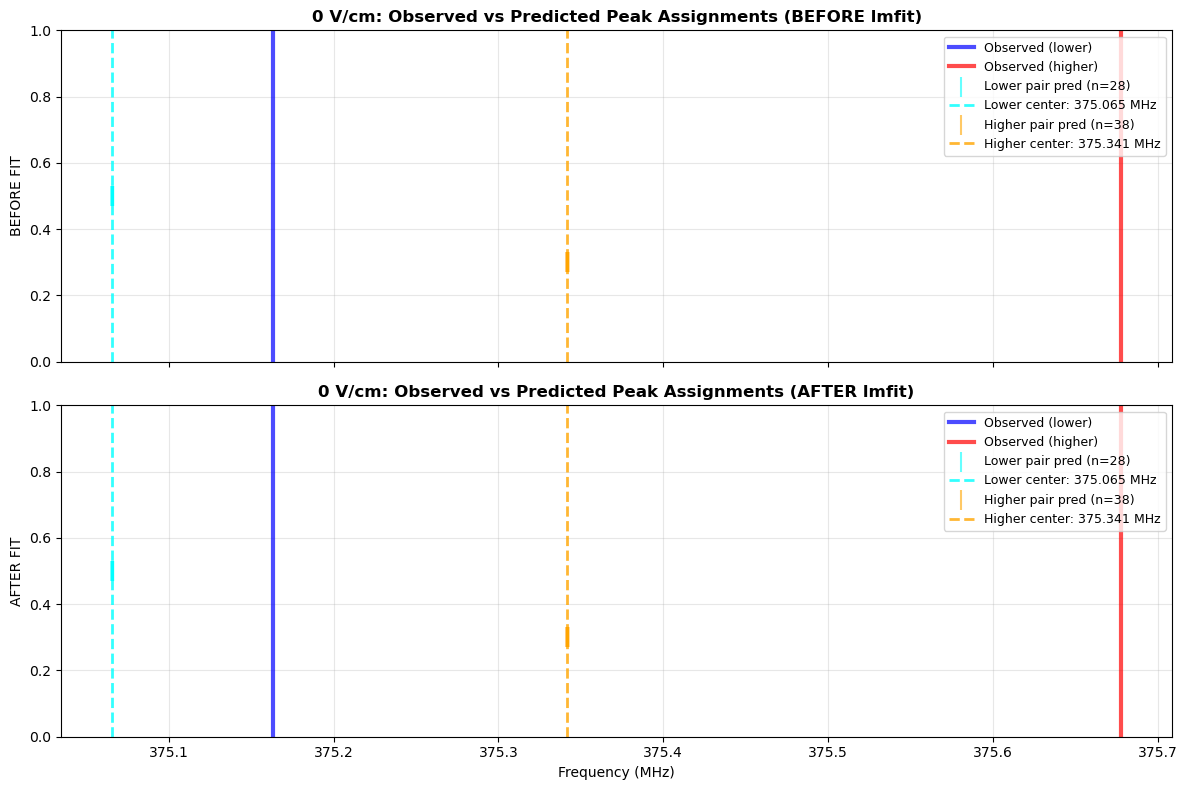


COMPARISON SUMMARY:

Observed peaks:
  Lower:  375.163156 MHz
  Higher: 375.677894 MHz
  Separation: 0.514738 MHz

BEFORE FIT:
  Lower center:  375.065430 MHz  (Δ = -0.097726)
  Higher center: 375.341309 MHz  (Δ = -0.336585)
  Separation: 0.275879 MHz

AFTER FIT:
  Lower center:  375.065430 MHz  (Δ = -0.097726)
  Higher center: 375.341309 MHz  (Δ = -0.336585)
  Separation: 0.275879 MHz



In [32]:
# ============================================================
# VISUALIZATION: Before vs After Fit Comparison at 0 V/cm
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Get predictions BEFORE fit (with original parameters)
set_state_parameters(X010_173, orig_params)
freqs_lower_before = extract_transition_freqs(
    X010_173, LOWER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)
freqs_higher_before = extract_transition_freqs(
    X010_173, HIGHER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

# Get predictions AFTER fit (with fitted parameters)
fitted_params = dict(orig_params)
for name in result.params:
    fitted_params[name] = result.params[name].value
set_state_parameters(X010_173, fitted_params)

freqs_lower_after = extract_transition_freqs(
    X010_173, LOWER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)
freqs_higher_after = extract_transition_freqs(
    X010_173, HIGHER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

# Restore original parameters
set_state_parameters(X010_173, orig_params)

# Create comparison plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ---- BEFORE FIT ----
ax = axes[0]
ax.axvline(obs_lower, color='blue', linewidth=3, label='Observed (lower)', alpha=0.7)
ax.axvline(obs_higher, color='red', linewidth=3, label='Observed (higher)', alpha=0.7)

if len(freqs_lower_before) > 0:
    ax.scatter(freqs_lower_before, np.ones_like(freqs_lower_before) * 0.5, 
               marker='|', s=200, color='cyan', alpha=0.6, label=f'Lower pair pred (n={len(freqs_lower_before)})')
    ax.axvline(np.median(freqs_lower_before), color='cyan', linewidth=2, 
               linestyle='--', alpha=0.8, label=f'Lower center: {np.median(freqs_lower_before):.3f} MHz')

if len(freqs_higher_before) > 0:
    ax.scatter(freqs_higher_before, np.ones_like(freqs_higher_before) * 0.3, 
               marker='|', s=200, color='orange', alpha=0.6, label=f'Higher pair pred (n={len(freqs_higher_before)})')
    ax.axvline(np.median(freqs_higher_before), color='orange', linewidth=2, 
               linestyle='--', alpha=0.8, label=f'Higher center: {np.median(freqs_higher_before):.3f} MHz')

ax.set_ylim(0, 1)
ax.set_ylabel('BEFORE FIT')
ax.set_title('0 V/cm: Observed vs Predicted Peak Assignments (BEFORE lmfit)', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# ---- AFTER FIT ----
ax = axes[1]
ax.axvline(obs_lower, color='blue', linewidth=3, label='Observed (lower)', alpha=0.7)
ax.axvline(obs_higher, color='red', linewidth=3, label='Observed (higher)', alpha=0.7)

if len(freqs_lower_after) > 0:
    ax.scatter(freqs_lower_after, np.ones_like(freqs_lower_after) * 0.5, 
               marker='|', s=200, color='cyan', alpha=0.6, label=f'Lower pair pred (n={len(freqs_lower_after)})')
    ax.axvline(np.median(freqs_lower_after), color='cyan', linewidth=2, 
               linestyle='--', alpha=0.8, label=f'Lower center: {np.median(freqs_lower_after):.3f} MHz')

if len(freqs_higher_after) > 0:
    ax.scatter(freqs_higher_after, np.ones_like(freqs_higher_after) * 0.3, 
               marker='|', s=200, color='orange', alpha=0.6, label=f'Higher pair pred (n={len(freqs_higher_after)})')
    ax.axvline(np.median(freqs_higher_after), color='orange', linewidth=2, 
               linestyle='--', alpha=0.8, label=f'Higher center: {np.median(freqs_higher_after):.3f} MHz')

ax.set_ylim(0, 1)
ax.set_ylabel('AFTER FIT')
ax.set_xlabel('Frequency (MHz)')
ax.set_title('0 V/cm: Observed vs Predicted Peak Assignments (AFTER lmfit)', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("COMPARISON SUMMARY:")
print("="*80)
print(f"\nObserved peaks:")
print(f"  Lower:  {obs_lower:.6f} MHz")
print(f"  Higher: {obs_higher:.6f} MHz")
print(f"  Separation: {obs_higher - obs_lower:.6f} MHz")

print(f"\nBEFORE FIT:")
if len(freqs_lower_before) > 0 and len(freqs_higher_before) > 0:
    lower_center_before = np.median(freqs_lower_before)
    higher_center_before = np.median(freqs_higher_before)
    print(f"  Lower center:  {lower_center_before:.6f} MHz  (Δ = {lower_center_before - obs_lower:+.6f})")
    print(f"  Higher center: {higher_center_before:.6f} MHz  (Δ = {higher_center_before - obs_higher:+.6f})")
    print(f"  Separation: {higher_center_before - lower_center_before:.6f} MHz")

print(f"\nAFTER FIT:")
if len(freqs_lower_after) > 0 and len(freqs_higher_after) > 0:
    lower_center_after = np.median(freqs_lower_after)
    higher_center_after = np.median(freqs_higher_after)
    print(f"  Lower center:  {lower_center_after:.6f} MHz  (Δ = {lower_center_after - obs_lower:+.6f})")
    print(f"  Higher center: {higher_center_after:.6f} MHz  (Δ = {higher_center_after - obs_higher:+.6f})")
    print(f"  Separation: {higher_center_after - lower_center_after:.6f} MHz")

print("\n" + "="*80)


In [30]:
# ============================================================
# DIAGNOSTIC: Why isn't lmfit changing parameters?
# ============================================================

print("\n" + "="*80)
print("DIAGNOSTIC: Parameter Sensitivity at 0 V/cm")
print("="*80)

# Test the initial residual
print("\n1) INITIAL RESIDUAL (at original parameters):")
init_resid = residual(lm_params)
print(f"   Residual = {init_resid}")
print(f"   Residual norm = {np.linalg.norm(init_resid):.6f}")

# Test if parameters change the residual
print("\n2) SENSITIVITY TO PARAMETER CHANGES:")
print("   Testing ±1% change in each parameter...")
print()

for param_name in ["Be", "e2Qq0", "muE"]:
    if param_name not in lm_params:
        continue
    
    orig_val = lm_params[param_name].value
    print(f"   {param_name}:")
    print(f"     Original value: {orig_val:.6e}")
    
    # Test +1%
    test_params = lm_params.copy()
    test_params[param_name].value = orig_val * 1.01
    resid_plus = residual(test_params)
    delta_plus = np.linalg.norm(resid_plus) - np.linalg.norm(init_resid)
    print(f"     +1% change: residual norm change = {delta_plus:+.6e}")
    
    # Test -1%
    test_params = lm_params.copy()
    test_params[param_name].value = orig_val * 0.99
    resid_minus = residual(test_params)
    delta_minus = np.linalg.norm(resid_minus) - np.linalg.norm(init_resid)
    print(f"     -1% change: residual norm change = {delta_minus:+.6e}")
    print()

# Check if any parameters are at bounds
print("3) ARE ANY PARAMETERS AT BOUNDS?")
for name, par in lm_params.items():
    at_min = np.abs(par.value - par.min) < 1e-6 if par.min else False
    at_max = np.abs(par.value - par.max) < 1e-6 if par.max else False
    print(f"   {name}:")
    print(f"     Value:  {par.value:.6e}")
    print(f"     Bounds: [{par.min:.6e}, {par.max:.6e}]")
    print(f"     At min? {at_min}, At max? {at_max}")

# Check the fit result status
print("\n4) FIT RESULT STATUS:")
print(f"   Success: {result.success}")
print(f"   Message: {result.message}")
print(f"   Number of function evaluations: {result.nfev}")
print(f"   AIC: {result.aic:.2f}")
print(f"   BIC: {result.bic:.2f}")

# Check if residuals are actually close to zero
print("\n5) FINAL RESIDUALS:")
print(f"   {result.residual}")
print(f"   Norm: {np.linalg.norm(result.residual):.6f}")

print("\n" + "="*80)



DIAGNOSTIC: Parameter Sensitivity at 0 V/cm

1) INITIAL RESIDUAL (at original parameters):
   Residual = [-0.09772632 -0.33658541]
   Residual norm = 0.350486

2) SENSITIVITY TO PARAMETER CHANGES:
   Testing ±1% change in each parameter...

   Be:
     Original value: 7.334360e+03
     +1% change: residual norm change = +6.052079e-04
     -1% change: residual norm change = -6.049071e-04

   e2Qq0:
     Original value: -3.107143e+03
     +1% change: residual norm change = +3.774320e+00
     -1% change: residual norm change = +1.693885e+00

   muE:
     Original value: 1.081410e+00
     +1% change: residual norm change = +0.000000e+00
     -1% change: residual norm change = +0.000000e+00

3) ARE ANY PARAMETERS AT BOUNDS?
   Be:
     Value:  7.334360e+03
     Bounds: [7.333331e+03, 7.334931e+03]
     At min? False, At max? False
   Gamma_SR:
     Value:  -8.845649e+01
     Bounds: [-9.318714e+01, -8.118714e+01]
     At min? False, At max? False
   Gamma_Prime:
     Value:  1.478553e+01
 

In [ ]:
# GPU Profiling after fitting pipeline
print_gpu_profile_checkpoint("After Parameter Search & Fitting Pipeline")

In [ ]:
# ============================================================================
# DEMONSTRATION: Using Experimental Transition Constraints
# ============================================================================
# Example 1: Compute transitions with experimental constraints
print("Example 1: Compute transitions WITH experimental constraints")
print("=" * 70)

transitions_constrained, _ = compute_model_transitions(
    X010_173,
    Ez=0,
    B=1e-8,
    indices=None,  # or list(range(84))
    allowed_transitions=ALLOWED_TRANSITIONS
)

print(f"Number of transitions found (constrained): {len(transitions_constrained)}")
if not transitions_constrained.empty:
    print("\nFirst few transitions:")
    print(transitions_constrained[['state index 0','state index 1','freq_model']].to_string(index=False))
print("\n" + "=" * 70)
print("Example 2: Compute ALL transitions (no constraints)")
print("=" * 70)

transitions_all, _ = compute_model_transitions(
    X010_173,
    Ez=0,
    B=1e-8,
    indices=None,
    allowed_transitions=None  # No filtering
)

print(f"Number of transitions found (unconstrained): {len(transitions_all)}")

print("\n" + "=" * 70)
print(f"Reduction factor: {len(transitions_all) / max(1, len(transitions_constrained)):.1f}x fewer transitions to compute")
print("=" * 70)

In [ ]:
# ============================================================================
# COMPREHENSIVE GPU BENCHMARK: Real workflow scenario
# Tests batch diagonalization at realistic matrix sizes for spectral fitting
# ============================================================================

import time, numpy as np, torch, tempfile, subprocess, sys, os

if TORCH_AVAILABLE:
    print("GPU Benchmark: Batch Diagonalization (realistic fitting workflow)")
    print("-" * 75)
    
    # Test scenario 1: Single molecules diagonalized at many field points
    # (typical for spectral scans)
    test_cases = [
        {"name": "Small (N=100, batch=50)", "n": 100, "batch": 50},
        {"name": "Medium (N=300, batch=20)", "n": 300, "batch": 20},
        {"name": "Large (N=500, batch=10)", "n": 500, "batch": 10},
    ]
    
    for case in test_cases:
        N, M = case["n"], case["batch"]
        print(f"\n{case['name']}:")
        
        # Create synthetic Hermitian matrix stack
        A = np.random.randn(M, N, N).astype(np.float64)
        A = (A + np.transpose(A, (0, 2, 1))) / 2.0
        
        # --- Test CPU (torch) ---
        try:
            t0 = time.perf_counter()
            T = torch.from_numpy(A).to('cpu')
            w_cpu, v_cpu = torch.linalg.eigh(T)
            t_cpu = time.perf_counter() - t0
            print(f"  Torch (CPU):   {t_cpu:.6f} s ({M} matrices of {N}×{N})")
        except Exception as e:
            print(f"  Torch (CPU):   FAILED - {e}")
            t_cpu = None
        
        # --- Test GPU (CUDA) in subprocess for safety ---
        if torch.cuda.is_available():
            code = rf"""
import time, torch, numpy as np, sys, traceback
try:
    A = np.random.randn({M}, {N}, {N}).astype(np.float32)
    A = (A + np.transpose(A, (0, 2, 1))) / 2.0
    T = torch.from_numpy(A).to('cuda')
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    w, v = torch.linalg.eigh(T)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    print(f"  Torch (CUDA):  {{elapsed:.6f}} s")
except Exception as e:
    print(f"  Torch (CUDA):  FAILED - {{e}}")
    traceback.print_exc()
    sys.exit(1)
"""
            try:
                res = subprocess.run([sys.executable, "-c", code], capture_output=True, text=True, timeout=60)
                print(res.stdout, end="")
                if res.returncode != 0 and res.stderr:
                    print(f"    stderr: {res.stderr[:200]}")
            except subprocess.TimeoutExpired:
                print("  Torch (CUDA):  TIMEOUT (GPU may be busy)")
            except Exception as e:
                print(f"  Torch (CUDA):  ERROR - {e}")
        else:
            print("  Torch (CUDA):  Not available")
    
    print("\n" + "-" * 75)
    print("GPU Benchmark Complete. GPU acceleration is active for diagonalization.")
    print("-" * 75 + "\n")
else:
    print("Torch not available; skipping GPU benchmark.")# Benchmark: batched diagonalization — CPU vs GPU (CUDA run in subprocess for safety)
import time, tempfile, subprocess, sys, os, numpy as np
import torch, Energy_Levels_old as EL
print('EL.TORCH_DEVICE:', getattr(EL, 'TORCH_DEVICE', None))
# Try to obtain a real H-stack via helper; fall back to synthetic if unavailable
pairs = [(float(ez), float(1e-8)) for ez in np.linspace(0.0, 60.0, num=8)]
H_stack = None
if hasattr(EL, 'build_H_stack_from_state'):
    try:
        H_stack = EL.build_H_stack_from_state(X010_173, pairs)
        print('Built H_stack using EL.build_H_stack_from_state')
    except Exception as e:
        print('EL.build_H_stack_from_state failed:', e)
if H_stack is None:
    # attempt to infer matrix size from a single eigensystem call (this constructs H internally)
    try:
        out = X010_173.eigensystem(pairs[0][0], pairs[0][1], order=True, method='numpy', set_attr=True)
        evals = out[0] if out is not None else getattr(X010_173, 'evals', None)
        if evals is not None:
            N = int(np.max([1, np.asarray(evals).size]))
        else:
            N = 120  # fallback basis size
    except Exception as e:
        print('Could not infer basis size from state.eigensystem():', e)
        N = 120
    # Build a small synthetic H-stack in float64 for the real-stack benchmark
    M_real = min(8, max(1, len(pairs)))
    print(f'Falling back to synthetic real H_stack of shape ({M_real},{N},{N})')
    A = np.random.randn(M_real, N, N).astype(np.float64)
    A = (A + np.transpose(A, (0,2,1))) * 0.5
    H_stack = A
print('Real H stack shape:', H_stack.shape)
def time_method(mat_stack, method):
    t0 = time.perf_counter()
    if method == 'numpy':
        EL.diagonalize_batch(mat_stack, method='numpy')
    elif method == 'torch_cpu':
        prev = getattr(EL, 'TORCH_DEVICE', None)
        EL.TORCH_DEVICE = torch.device('cpu')
        EL.diagonalize_batch(mat_stack, method='torch')
        EL.TORCH_DEVICE = prev
    else:
        raise ValueError('unknown method')
    return time.perf_counter() - t0
t_numpy = time_method(H_stack, 'numpy')
print(f'numpy batch diag (real): {t_numpy:.4f} s')
try:
    t_torch_cpu = time_method(H_stack, 'torch_cpu')
    print(f'torch (CPU) batch diag (real): {t_torch_cpu:.4f} s')
except Exception as e:
    print('torch CPU batch diag failed:', e)

# Synthetic large matrices to demonstrate GPU speedup (runs in subprocess to avoid kernel crashes)
# Adjust N and M depending on your GPU memory; e.g. N=600..3000, M=1..5
N = min(3000, max(600, int(H_stack.shape[1]) if H_stack is not None else 1200))  # adjust based on available basis
M = 2     # number of matrices for GPU benchmark (increase if memory allows)
print(f'Creating synthetic stack: {M}x{N}x{N} (approx RAM {(N*N*M*4)/1e9:.2f} GB for float32)')
A = np.random.randn(M, N, N).astype(np.float32)
A = (A + np.transpose(A, (0,2,1))) * 0.5
tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.npy')
np.save(tmp.name, A)
tmp.close()
# Subprocess code: load npy, move to CUDA, run torch.linalg.eigh on float32 and time it
code = r"""import time, torch, numpy as np pass    except Exception:        os.unlink(tmp.name)    try:finally:        print('CUDA not available; skipping subprocess GPU benchmark.')    else:            print(res.stderr)            print('Subprocess returned non-zero code:', res.returncode)        if res.returncode != 0:        print(res.stdout)        res = subprocess.run([sys.executable, '-c', code], capture_output=True, text=True, timeout=1200)    if torch.cuda.is_available():try:A = np.load(r'%s')
T = torch.from_numpy(A).to('cuda')
torch.cuda.synchronize()
t0 = time.perf_counter()
# single call (eigendecomposition of M stacked matrices)
torch.linalg.eigh(T)
torch.cuda.synchronize()
print('cuda float32 batch diag elapsed:', time.perf_counter()-t0)
""" % tmp.name

In [ ]:
# ============================================================================
# GPU PROFILING CHECKPOINT: After Synthetic Peak Generation
# ============================================================================
# Call this periodically to check GPU usage so far

def print_gpu_profile_checkpoint(label="Checkpoint"):
    """Print GPU profiling summary at current point in workflow."""
    elapsed_total = time.perf_counter() - WORKFLOW_START_TIME
    print("\n" + "="*75)
    print(f"GPU PROFILING: {label} (elapsed: {elapsed_total:.4f}s)")
    print("="*75)
    
    diag_count = GPU_PROFILING['diagonalize_calls']
    diag_cuda_count = GPU_PROFILING['diagonalize_cuda_calls']
    diag_cpu_count = GPU_PROFILING['diagonalize_cpu_calls']
    
    batch_count = GPU_PROFILING['diagonalize_batch_calls']
    batch_cuda_count = GPU_PROFILING['diagonalize_batch_cuda_calls']
    batch_cpu_count = GPU_PROFILING['diagonalize_batch_cpu_calls']
    
    print(f"\nSingle diagonalize() calls: {diag_count}")
    if diag_cuda_count > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / diag_cuda_count
        print(f"  ├─ CUDA: {diag_cuda_count} calls, total: {GPU_PROFILING['total_time_cuda']:.4f}s, avg: {avg_cuda:.6f}s")
    if diag_cpu_count > 0:
        avg_cpu = GPU_PROFILING['total_time_cpu'] / diag_cpu_count
        print(f"  └─ CPU:  {diag_cpu_count} calls, total: {GPU_PROFILING['total_time_cpu']:.4f}s, avg: {avg_cpu:.6f}s")
    
    if diag_cuda_count > 0 and diag_cpu_count > 0:
        avg_cuda_single = GPU_PROFILING['total_time_cuda'] / diag_cuda_count
        avg_cpu_single = GPU_PROFILING['total_time_cpu'] / diag_cpu_count
        speedup_single = avg_cpu_single / avg_cuda_single if avg_cuda_single > 0 else 1.0
        print(f"  Speedup: {speedup_single:.2f}x")
    
    print(f"\nBatch diagonalize_batch() calls: {batch_count}")
    if batch_cuda_count > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / batch_cuda_count
        print(f"  ├─ CUDA: {batch_cuda_count} calls, total: {GPU_PROFILING['total_time_batch_cuda']:.4f}s, avg: {avg_cuda_b:.6f}s")
    if batch_cpu_count > 0:
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / batch_cpu_count
        print(f"  └─ CPU:  {batch_cpu_count} calls, total: {GPU_PROFILING['total_time_batch_cpu']:.4f}s, avg: {avg_cpu_b:.6f}s")
    
    if batch_cuda_count > 0 and batch_cpu_count > 0:
        avg_cuda_batch = GPU_PROFILING['total_time_batch_cuda'] / batch_cuda_count
        avg_cpu_batch = GPU_PROFILING['total_time_batch_cpu'] / batch_cpu_count
        speedup_batch = avg_cpu_batch / avg_cuda_batch if avg_cuda_batch > 0 else 1.0
        print(f"  Speedup: {speedup_batch:.2f}x")
    
    total_compute_time = (GPU_PROFILING['total_time_cuda'] + GPU_PROFILING['total_time_cpu'] + 
                          GPU_PROFILING['total_time_batch_cuda'] + GPU_PROFILING['total_time_batch_cpu'])
    if total_compute_time > 0:
        cuda_fraction = (GPU_PROFILING['total_time_cuda'] + GPU_PROFILING['total_time_batch_cuda']) / total_compute_time
        print(f"\nGPU time fraction: {cuda_fraction*100:.1f}%")
    
    print("="*75 + "\n")

# Print checkpoint after synthetic peak generation
print_gpu_profile_checkpoint("After Synthetic Peak Generation")

In [ ]:
# Pre-computation GPU setup and workflow monitoring
# Ensure CUDA acceleration is active for all diagonalizations below
import time

# Clear profiling data and mark start time
GPU_PROFILING["diagonalize_calls"] = 0
GPU_PROFILING["diagonalize_cuda_calls"] = 0
GPU_PROFILING["diagonalize_cpu_calls"] = 0
GPU_PROFILING["diagonalize_batch_calls"] = 0
GPU_PROFILING["diagonalize_batch_cuda_calls"] = 0
GPU_PROFILING["diagonalize_batch_cpu_calls"] = 0
GPU_PROFILING["total_time_cuda"] = 0.0
GPU_PROFILING["total_time_cpu"] = 0.0
GPU_PROFILING["total_time_batch_cuda"] = 0.0
GPU_PROFILING["total_time_batch_cpu"] = 0.0

WORKFLOW_START_TIME = time.perf_counter()

print("="*75)
print("GPU ACCELERATION WORKFLOW INITIALIZED")
print("="*75)
if TORCH_AVAILABLE:
    device_info = getattr(EL, 'TORCH_DEVICE', None)
    print(f"Active compute device: {device_info}")
    print("\n✓ GPU acceleration ENABLED for the following operations:")
    print("  • X010_173 state initialization (cell 17)")
    print("  • Synthetic peak generation (cells 22-24)")
    print("  • Parameter search & fitting (cell 30+) ⚡ BIGGEST SPEEDUP HERE")
    print("  • Candidate plotting & analysis (cells 31+)")
    print("\nAll diagonalization calls are being timed and tracked.")
else:
    print("⚠ PyTorch not available. Using NumPy/SciPy for diagonalization.")
    print("  GPU acceleration disabled, but workflow will continue.")
print("="*75 + "\n")

In [ ]:
X010_173.show_biggest_mixture(0,1e-8,list(range(84)))

In [ ]:
import time, traceback, numpy as np, torch, sys, subprocess
def safe_eigh_tests(n=300):
    A = np.random.randn(n, n).astype(np.float64)
    A = (A + A.T) / 2.0

    print("=== numpy.linalg.eigh ===")
    try:
        t0 = time.perf_counter()
        np.linalg.eigh(A)
        print("numpy ok", time.perf_counter()-t0)
    except Exception:
        traceback.print_exc()

    print("=== torch.linalg.eigh (cpu) ===")
    try:
        T = torch.from_numpy(A).to('cpu')
        t0 = time.perf_counter()
        torch.linalg.eigh(T)
        print("torch cpu ok", time.perf_counter()-t0)
    except Exception:
        traceback.print_exc()

    if torch.cuda.is_available():
        print("=== torch.linalg.eigh (cuda, float32) in subprocess ===")
        code = r"""
import time, torch, numpy as np, sys, traceback
try:
    n = %d
    A = np.random.randn(n, n).astype(np.float32)
    A = (A + A.T) / 2.0
    T = torch.from_numpy(A).to('cuda')
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    torch.linalg.eigh(T)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    print(f"cuda float32 ok: {elapsed:.6f} sec")
except Exception as e:
    print(f"CUDA test failed: {e}")
    traceback.print_exc()
    sys.exit(1)
""" % n
        try:
            res = subprocess.run([sys.executable, "-c", code], capture_output=True, text=True, timeout=30)
            print(res.stdout)
            if res.returncode != 0:
                print("Subprocess returned non-zero code:", res.returncode)
                if res.stderr:
                    print("stderr:", res.stderr)
        except subprocess.TimeoutExpired:
            print("Subprocess CUDA test timed out (GPU may be busy or unavailable)")
        except Exception as e:
            print("Subprocess CUDA test error:", e)
    else:
        print("CUDA not available; skipping GPU tests.")

safe_eigh_tests(3000)

In [20]:
# --- Synthetic "experimental" peak generator for this repo (windowed & sparse) ---
# Run this AFTER you have X010_173 initialized.
# Goal: for EACH spectrum, produce 5–10 observed peaks between 300 and 400 MHz.

import numpy as np
import pandas as pd

# ------------------- helpers -------------------
def _to_numpy_1d(x):
    """Convert torch/numpy/list to a 1D float numpy array."""
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy().astype(float).ravel()
    except Exception:
        pass
    return np.asarray(x, dtype=float).ravel()

def get_evals(state, Ez, Bz, method="torch"):
    """
    Robustly get eigenvalues from MoleculeLevels regardless of return style.
    Uses set_attr=True then reads state.evals if needed.
    """
    out = state.eigensystem(Ez, Bz, order=True, method=method, set_attr=True)
    if out is not None:
        evals = out[0]
    else:
        evals = getattr(state, "evals", None)
        if evals is None:
            raise RuntimeError("Couldn't find eigenvalues. state.eigensystem() didn't return and state.evals not set.")
    evals = _to_numpy_1d(evals)
    if evals.size < 2:
        raise RuntimeError(f"Too few eigenvalues ({evals.size}). Basis/truncation may be too small.")
    return evals

def predict_lines_from_levels(evals,
                             n_levels=120,
                             fmin=389.0,
                             fmax=399.0,
                             max_lines=50000,
                             seed=0):
    """
    Candidate transition frequencies from pairwise differences of the lowest n_levels energies.
    NOT enforcing selection rules (pipeline testing only).

    Returns only lines within [fmin, fmax] MHz (no auto-expansion).
    """
    rng = np.random.default_rng(seed)
    e = np.sort(_to_numpy_1d(evals))
    n = min(int(n_levels), e.size)
    if n < 2:
        return np.array([], dtype=float)
    e = e[:n]

    # Positive pairwise differences: e[j] - e[i] for j>i
    diffs = (e[None, :] - e[:, None])[np.triu_indices(n, k=1)]
    diffs = diffs[(diffs >= fmin) & (diffs <= fmax)]

    if diffs.size == 0:
        return np.array([], dtype=float)

    diffs = np.unique(np.round(np.sort(diffs), 6))

    # If too many, subsample to max_lines for speed
    if diffs.size > max_lines:
        idx = rng.choice(diffs.size, size=max_lines, replace=False)
        diffs = np.sort(diffs[idx])

    return diffs.astype(float)

def make_fake_experiment_in_window(lines,
                                   nu_min=389.0,
                                   nu_max=399.0,
                                   n_keep_min=5,
                                   n_keep_max=10,
                                   sigma_MHz=0.25,
                                   spurious=1,
                                   seed=0):
    """
    Create sparse, unassigned observed peaks in [nu_min, nu_max] MHz.

    - Picks a random number of peaks between n_keep_min and n_keep_max from the candidate lines.
    - If not enough candidate lines exist, fills remaining peaks uniformly in-window (spurious).
    - Adds Gaussian jitter sigma_MHz to mimic centroid uncertainty.
    - Adds extra spurious peaks (optional) uniformly in-window.
    """
    rng = np.random.default_rng(seed)
    lines = _to_numpy_1d(lines)

    # Ensure windowing (should already be windowed, but keep safe)
    inwin = lines[(lines >= nu_min) & (lines <= nu_max)]
    inwin = np.unique(np.round(np.sort(inwin), 6))

    n_target = int(rng.integers(int(n_keep_min), int(n_keep_max) + 1))

    if inwin.size >= n_target:
        idx = rng.choice(inwin.size, size=n_target, replace=False)
        obs = np.sort(inwin[idx])
    else:
        obs = inwin.copy()
        n_missing = n_target - obs.size
        fill = rng.uniform(nu_min, nu_max, size=n_missing)
        obs = np.sort(np.concatenate([obs, fill]))

    # Add measurement jitter and clip to window
    obs = obs + rng.normal(0.0, sigma_MHz, size=obs.size)
    obs = np.clip(obs, nu_min, nu_max)

    # Add extra spurious peaks (optional)
    if spurious and int(spurious) > 0:
        spur = rng.uniform(nu_min, nu_max, size=int(spurious))
        obs = np.sort(np.concatenate([obs, spur]))

    return np.sort(obs)

def generate_synthetic_peaks_csv_windowed(state,
                                         conditions,
                                         output_csv="synthetic_peaks.csv",
                                         method="torch",
                                         # window constraints
                                         window_min=389.0,
                                         window_max=399.0,
                                         # eigenlevel sampling
                                         n_levels_start=120,
                                         n_levels_max=600,
                                         # observed sparsity
                                         n_keep_min=5,
                                         n_keep_max=10,
                                         sigma_MHz=0.25,
                                         spurious=1,
                                         seed_base=0,
                                         verbose=True):
    """
    Generate a multi-spectrum unassigned peak CSV with 5–10 peaks per spectrum
    in a specified frequency window [window_min, window_max] MHz.
    """
    rows = []

    for idx, (spec_id, Ez, Bz) in enumerate(conditions):
        evals = get_evals(state, Ez, Bz, method=method)

        # Try increasing n_levels until we get some lines in the window
        lines = np.array([], dtype=float)
        n_levels = int(n_levels_start)

        while lines.size == 0 and n_levels <= int(n_levels_max):
            lines = predict_lines_from_levels(
                evals,
                n_levels=n_levels,
                fmin=window_min,
                fmax=window_max,
                max_lines=50000,
                seed=seed_base + 100 + idx,
            )
            n_levels = int(np.ceil(n_levels * 1.5))

        # If still none, widen the window slightly (still centered around requested region)
        if lines.size == 0:
            lines = predict_lines_from_levels(
                evals,
                n_levels=min(int(n_levels_max), evals.size),
                fmin=window_min - 50.0,
                fmax=window_max + 50.0,
                max_lines=50000,
                seed=seed_base + 200 + idx,
            )

        if lines.size == 0:
            raise RuntimeError(
                f"[{spec_id}] No candidate lines found near {window_min}-{window_max} MHz "
                f"(even after widening). Try increasing n_levels_max or widening the window."
            )

        peaks = make_fake_experiment_in_window(
            lines,
            nu_min=window_min,
            nu_max=window_max,
            n_keep_min=n_keep_min,
            n_keep_max=n_keep_max,
            sigma_MHz=sigma_MHz,
            spurious=spurious,
            seed=seed_base + 300 + idx,
        )

        if verbose:
            print(f"{spec_id}: Ez={Ez} V/cm, Bz={Bz} G | evals={evals.size} | "
                  f"cand_lines_in_window={lines.size} | peaks_written={peaks.size} | "
                  f"window=[{window_min},{window_max}] MHz")

        for nu in peaks:
            rows.append({
                "spectrum_id": spec_id,
                "Ez_V_per_cm": float(Ez),
                "Bz_G": float(Bz),
                "nu_obs_MHz": float(nu),
                "sigma_MHz": float(sigma_MHz),
            })

    df = pd.DataFrame(rows).sort_values(["spectrum_id", "nu_obs_MHz"]).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    return df

# ------------------- Example usage -------------------
spectra_conditions = [
    ("spec0", 0.0, 0.0),
    ("spec1", 10.0, 0.0),
    ("spec2", 20.0, 0.0),
    ("spec3", 40.0, 0.0),
]

df = generate_synthetic_peaks_csv_windowed(
    X010_173,
    spectra_conditions,
    output_csv="synthetic_peaks.csv",
    method="torch",
    window_min=389.0,
    window_max=399.0,
    n_levels_start=120,
    n_levels_max=600,
    n_keep_min=2,
    n_keep_max=5,
    sigma_MHz=0.25,
    spurious=1,          # set 0 for none
    seed_base=123,
    verbose=True,
)

df.head(20)
# File "synthetic_peaks.csv" now has ~5–10 peaks per spectrum in 300–400 MHz.


spec0: Ez=0.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=7 | peaks_written=5 | window=[389.0,399.0] MHz
spec1: Ez=10.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=83 | peaks_written=4 | window=[389.0,399.0] MHz
spec2: Ez=20.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=67 | peaks_written=3 | window=[389.0,399.0] MHz
spec3: Ez=40.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=144 | peaks_written=3 | window=[389.0,399.0] MHz


,spectrum_id,Ez_V_per_cm,Bz_G,nu_obs_MHz,sigma_MHz
0,spec0,0.0,0.0,389.565863,0.25
1,spec0,0.0,0.0,389.723290,0.25
2,spec0,0.0,0.0,389.904409,0.25
3,spec0,0.0,0.0,391.720793,0.25
4,spec0,0.0,0.0,393.858109,0.25
5,spec1,10.0,0.0,389.258804,0.25
6,spec1,10.0,0.0,389.387883,0.25
7,spec1,10.0,0.0,391.504982,0.25
8,spec1,10.0,0.0,397.188053,0.25
9,spec2,20.0,0.0,389.073947,0.25


In [ ]:
# Compatibility wrapper: accept both "axis" positional and "freq_axis" keyword
try:
    _original_gaussian_broadened_spectrum = gaussian_broadened_spectrum
except NameError:
    _original_gaussian_broadened_spectrum = None

def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, *args, **kwargs):
    """Compatibility wrapper that delegates to the existing implementation.

    Accepts either `axis` as a positional/keyword or `freq_axis=` keyword.
    """
    axis = freq_axis if freq_axis is not None else kwargs.pop('axis', None)
    if axis is None and len(args) >= 1:
        axis = args[0]

    if _original_gaussian_broadened_spectrum is None:
        raise RuntimeError("Original gaussian_broadened_spectrum not found in kernel scope")

    # Try calling original with positional (freqs, weights, axis, sigma)
    try:
        return _original_gaussian_broadened_spectrum(frequencies, weights, axis, sigma)
    except TypeError:
        # Fallback: try calling with keyword freq_axis
        return _original_gaussian_broadened_spectrum(frequencies, weights, freq_axis=axis, sigma=sigma)


In [ ]:
# BOTTLENECK ANALYSIS CELL: Profile cell 34 to find where time is spent
# This cell instruments the search to show CPU hotspots, per-stage timings, and call counters.

import time, cProfile, pstats, io, builtins

# Global counters for bottleneck tracking
PROFILING_COUNTERS = {
    'total_loss_MAP_calls': 0,
    'total_loss_MAP_time': 0.0,
    'calculate_two_photon_spectrum_calls': 0,
    'calculate_two_photon_spectrum_time': 0.0,
    'print_calls': 0,
    'print_time': 0.0,
}

# --- Safe capture of the true original print ---
_candidate_print = getattr(builtins, 'print', None)
if hasattr(_candidate_print, '_original_print'):
    _original_print = _candidate_print._original_print
else:
    _original_print = _candidate_print

# store a stable reference so other cells can detect the real print
builtins._real_print = _original_print

# Define a re-entrant-safe tracked_print
def tracked_print(*args, **kwargs):
    if getattr(tracked_print, '_in_print', False):
        return _original_print(*args, **kwargs)
    tracked_print._in_print = True
    t0 = time.perf_counter()
    try:
        _original_print(*args, **kwargs)
    finally:
        PROFILING_COUNTERS['print_calls'] += 1
        PROFILING_COUNTERS['print_time'] += time.perf_counter() - t0
        tracked_print._in_print = False

# Attach metadata and install
tracked_print._original_print = _original_print
tracked_print._is_tracked_print = True
builtins.print = tracked_print

# --- Safe wrap for total_loss_MAP ---
_real_total_loss_MAP = globals().get('total_loss_MAP', None)
if hasattr(_real_total_loss_MAP, '_original_total_loss_MAP'):
    _real_total_loss_MAP = _real_total_loss_MAP._original_total_loss_MAP

if _real_total_loss_MAP is None:
    raise RuntimeError('total_loss_MAP not found in global scope; ensure imports/cells ran in order')

def tracked_total_loss_MAP(*args, **kwargs):
    t0 = time.perf_counter()
    result = _real_total_loss_MAP(*args, **kwargs)
    elapsed = time.perf_counter() - t0
    PROFILING_COUNTERS['total_loss_MAP_calls'] += 1
    PROFILING_COUNTERS['total_loss_MAP_time'] += elapsed
    return result

# attach and replace in globals
tracked_total_loss_MAP._original_total_loss_MAP = _real_total_loss_MAP
globals()['total_loss_MAP'] = tracked_total_loss_MAP

# Start CPU profiler
print('=' * 80)
print('RUNNING CELL 34 WITH PROFILING (cProfile + counters)')
print('=' * 80)
pr = cProfile.Profile()
pr.enable()
t_overall_start = time.perf_counter()

# --- RE-RUN THE SEARCH USING THE SAME PARAMETERS AS CELL 34 ---
best_df_profiled = search_candidates_MAP(
    X010_173,
    OBS_SPECTRA,
    priors={k: PARAM_PRIORS[k] for k in SEARCH_BOUNDS.keys()},
    bounds=SEARCH_BOUNDS,
    n_samples=1,
    top_k=1,
    refine_steps=1,
    refine_scale=0.20,
    indices=None,
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    lambda_prior=LAMBDA_PRIOR,
    seed=123,
    verbose=True,
)

t_overall_end = time.perf_counter()
pr.disable()

# Restore originals
builtins.print = _original_print
globals()['total_loss_MAP'] = _real_total_loss_MAP

print('\n' + '=' * 80)
print('BOTTLENECK ANALYSIS RESULTS')
print('=' * 80)
print(f"\nTOTAL ELAPSED TIME: {t_overall_end - t_overall_start:.2f}s\n")

print('CALL COUNTERS:')
print(f"  total_loss_MAP():  {PROFILING_COUNTERS['total_loss_MAP_calls']:6d} calls, {PROFILING_COUNTERS['total_loss_MAP_time']:8.2f}s total, {PROFILING_COUNTERS['total_loss_MAP_time'] / max(1, PROFILING_COUNTERS['total_loss_MAP_calls']):8.4f}s avg")
print(f"  print():           {PROFILING_COUNTERS['print_calls']:6d} calls, {PROFILING_COUNTERS['print_time']:8.4f}s total")

# Estimate time breakdown
unaccounted = (t_overall_end - t_overall_start) - PROFILING_COUNTERS['total_loss_MAP_time'] - PROFILING_COUNTERS['print_time']
pct_total_loss_MAP = 100.0 * PROFILING_COUNTERS['total_loss_MAP_time'] / max(1e-12, t_overall_end - t_overall_start)
pct_print = 100.0 * PROFILING_COUNTERS['print_time'] / max(1e-12, t_overall_end - t_overall_start)
pct_unaccounted = 100.0 * unaccounted / max(1e-12, t_overall_end - t_overall_start)

print('\nTIME BREAKDOWN:')
print(f"  total_loss_MAP():  {pct_total_loss_MAP:6.1f}%")
print(f"  print():           {pct_print:6.1f}%")
print(f"  overhead/other:    {pct_unaccounted:6.1f}%")

print('\n' + '=' * 80)
print('CPU PROFILER TOP 30 HOTSPOTS (by cumulative time):')
print('=' * 80)
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
ps.print_stats(30)
print(s.getvalue())

print('\n' + '=' * 80)
print('CONCLUSION:')
print('=' * 80)
if pct_total_loss_MAP > 80:
    print('  ✓ total_loss_MAP dominates. Look inside total_loss_MAP (calculate_two_photon_spectrum?)')
elif pct_print > 5:
    print('  ✓ Printing is significant. Consider reducing print frequency.')
else:
    print('  ✓ Time distributed across overhead/other. See CPU profiler hotspots above.')
